In [1]:
# !pip install --upgrade seaborn pandas

# Montar Drive e importar las primeras librerías

In [2]:
# Montar Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importar las primeras librerías

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install gdown==4.6.0
import gdown
!pip install openpyxl

  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0


# Cargar Excel por pestañas y separar la información en columnas

Cargamos cada pestaña del excel por separado, para realizar cleaning básico y separar los elementos. Una vez tenemos tablas limpias y separada en columnas, concatenamos todas las pestañas formando un dataset final con todos los episodios.

In [4]:
try:
    df = pd.read_excel('/content/drive/MyDrive/CAPSTONE/preprocessing_wip_Maite/transcripts.xlsx', index_col=None, header=None, sheet_name=None)

    dfs_list = []

    for sheet_name, df in df.items():
        df[['Temporada', 'Episodio']] = df.iloc[0, :].str.split('x', expand=True)
        df[['Episodio', 'Titulo']] = df['Episodio'].str.split('-', expand=True)

        split_cols = df.iloc[:, 0].astype(str).str.split(':', n=1, expand=True)

        if split_cols.shape[1] == 2:
            df[['Personaje', 'Texto']] = split_cols
        else:
            df['Personaje'] = None
            df['Texto'] = df.iloc[:, 0]

        temporada_value = df['Temporada'].iloc[0]
        episodio_value = df['Episodio'].iloc[0]
        titulo_value = df['Titulo'].iloc[0]

        df['Temporada'] = df['Temporada'].fillna(temporada_value)
        df['Episodio'] = df['Episodio'].fillna(episodio_value)
        df['Titulo'] = df['Titulo'].fillna(titulo_value)
        df = df.drop(df.index[0])

        dfs_list.append(df)

    if dfs_list:
        final_df = pd.concat(dfs_list, ignore_index=True)
        final_df = final_df.drop(final_df.columns[0], axis=1)
        output_path = '/content/drive/MyDrive/CAPSTONE/preprocessing_wip_Maite/final_df.xlsx'
        final_df.to_excel(output_path, index=False)
    else:
        print("No dataframes were processed.")

except ValueError as e:
    print(f'Error de formato del archivo Excel: {e}')
except FileNotFoundError as e:
    print(f'Error al encontrar el archivo: {e}')
except pd.errors.ParserError as e:
    print(f'Error al analizar el archivo Excel: {e}')
except Exception as e:
    print(f'Error desconocido: {e}')

# <font color='red'>PREPROCESAMIENTO</font>

## Limpieza básica del dataset

### Homogeneizar los nombres de los personajes y quedarnos sólo con los principales

In [5]:
# Mostramos la lista de los personajes presentes en nuestro dataset inicial, podemos observar varios nombres repetidos o escritos de manera ligeramente distinta

final_df['Personaje'] = final_df['Personaje'].str.lower()
personajes = final_df['Personaje'].unique()
personajes = sorted(personajes)
personajes

['',
 'abogado',
 'administrator',
 'agent',
 'agent on phone',
 'all three women',
 'almacenero',
 'andrea',
 'andrew',
 'answering machine',
 'antonio',
 'artie',
 'asac ramey',
 'attorney',
 'auditor',
 'badger',
 'barry',
 'bartender',
 'ben',
 'biker',
 'bingo',
 'bobby',
 'bogdan',
 'bolsa',
 'both',
 'brock',
 'buyer',
 'camarera',
 'car wash owner',
 'car wash woman',
 'cara',
 'carmen',
 'cartelguy',
 'casa',
 'chad',
 'chad’s girlfriend',
 'charlie rose',
 'chemist',
 'chow',
 'chris',
 'clovis',
 'colleen',
 'combo',
 'commercial guy #1',
 'commercial guy #2',
 'cop',
 'counselor',
 'coworker',
 'crackman',
 'customer',
 'cynthia',
 'dan',
 'darla',
 'dea agent 1',
 'dealer',
 'declan',
 'desguace',
 'doctor',
 'don eladio',
 'donald',
 'dorothy',
 'dr. bravenec',
 'dr. delcavoli',
 'driver',
 'drug dealer',
 'elliott',
 'elliott schwartz',
 'emilio',
 'empleado',
 'employee',
 'empresa_plagas',
 'emt',
 'enfermera',
 'enfermero',
 'enfermo',
 'everyone',
 'farley',
 'france

In [6]:
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Homogeneizamos los nombres de los personajes más importantes que están escritos de manera diferente

final_df['Personaje'].replace(['walt jr', 'hank(on the news)', 'reporter(on the news)', 'walter junior', 'walter(answering machine)', 'jesse(answering machine)', 'jane’s voicemail', 'walt', 'tv', 'elliott schwartz', 'gretchen schwartz', 'junior', 'gus', 'kaylie', 'ken', 'real estate agent', 'walt','neo-nazi','dealer','francesa','skyler (voicemail)','markert','lyda','neo nazi','drug dealer','asac ramey','ramey', 'merkert','pete', 'walt jr','walt','junior','asac ramey','markert', 'gomez'], ['walter jr', 'hank', 'reporter', 'walter jr', 'walter', 'jesse', 'jane', 'walter', 'tv', 'elliott', 'gretchen', 'walter jr', 'gustavo', 'kaylee', 'kenny', 'realtor', 'walter','neonazi','drug-dealer','francesca','skyler','merkert','lydia','neonazi','drug-dealer','sac ramey','sac ramey','merkert','skinny pete', 'walter jr','walter','walter jr','ramey','merkert', 'steve'], inplace=True)

# No tocamos Skyler (Walt's Imagination)

In [7]:
# Extraemos el número de líneas por cada personaje para poder filtrar aquellos que son secundarios o que intervienen muy poco a lo largo de la serie.

num_rows_per_personaje = final_df['Personaje'].value_counts().sort_values(ascending=False)

# Mostrar todas las filas para poder elegir el punto de corte
pd.set_option('display.max_rows', None)

num_rows_per_personaje

# Observando el número de filas de cada personaje, decidimos hacer el corte en 340.

,count
Personaje,
walter,4085
,3339
jesse,2184
skyler,1708
hank,1315
scene,980
saul,672
marie,669
mike,617


In [8]:
# Eliminamos los personajes que intervienen menos de 340 veces pero dejamos las líneas vacías

personajes_principales = num_rows_per_personaje[num_rows_per_personaje > 340].index

# personajes_principales

# personajes_secundarios = num_rows_per_personaje[num_rows_per_personaje <= 340].index

# personajes_secundarios

final_df = final_df[final_df['Personaje'].isin(personajes_principales)]

# Calculamos el número de filas retiradas del dataset para medir el impacto de esta acción.

final_df.Texto.value_counts().sum()

16402

In [9]:
# Sobreescribimos el final_df

output_path = '/content/drive/MyDrive/CAPSTONE/preprocessing_wip_Maite/final_df.xlsx'

final_df.to_excel(output_path, index=False)

### Crear nueva columna de Personaje_id

In [10]:
# Convertirmos los personajes en números para poder pasárselos a los algoritmos de Machine Learning más tarde.

!pip install scikit-learn

from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Initialize the Label Encoder
le = LabelEncoder()

# Fit the encoder and transform the 'person' column into numeric values
final_df['Personaje_id'] = le.fit_transform(final_df['Personaje'])

# print(final_df.head(2))

In [11]:
final_df.shape

(16402, 6)

### Analizar los tipos de variables y transformar las variables categóricas pertinentes en numéricas

In [12]:
# Convertir temporada y episodio en variables numéricas

final_df['Temporada'] = final_df['Temporada'].astype(int)
final_df['Episodio'] = final_df['Episodio'].astype(int)

# final_df.dtypes

In [13]:
final_df.shape

(16402, 6)

## Importar las Librerías necesarias para preprocesar texto

In [14]:
# Importar las bibliotecas necesarias para el preprocesamiento

import re
import nltk

# Importar los recursos necesarios de sus respectivos módulos
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# from itertools import combinations

In [15]:
# Importar más recursos
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Inicializar las librerías lemmatizer y stopwords.
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Inspeccionar Stop Words y definir Filler Words si fuera necesario

In [16]:
for word in sorted(stop_words):
  print(word)

a
about
above
after
again
against
ain
all
am
an
and
any
are
aren
aren't
as
at
be
because
been
before
being
below
between
both
but
by
can
couldn
couldn't
d
did
didn
didn't
do
does
doesn
doesn't
doing
don
don't
down
during
each
few
for
from
further
had
hadn
hadn't
has
hasn
hasn't
have
haven
haven't
having
he
her
here
hers
herself
him
himself
his
how
i
if
in
into
is
isn
isn't
it
it's
its
itself
just
ll
m
ma
me
mightn
mightn't
more
most
mustn
mustn't
my
myself
needn
needn't
no
nor
not
now
o
of
off
on
once
only
or
other
our
ours
ourselves
out
over
own
re
s
same
shan
shan't
she
she's
should
should've
shouldn
shouldn't
so
some
such
t
than
that
that'll
the
their
theirs
them
themselves
then
there
these
they
this
those
through
to
too
under
until
up
ve
very
was
wasn
wasn't
we
were
weren
weren't
what
when
where
which
while
who
whom
why
will
with
won
won't
wouldn
wouldn't
y
you
you'd
you'll
you're
you've
your
yours
yourself
yourselves


In [17]:
# No definimos filler words. No queremos quitar estas palabras del dataset ya que pueden ser de utilidad para algunos Lexicones con capacidad de analizar el lenguaje coloquial como el Vader.

# filler_words = {'um', 'got', 'uh', 'like', "youre", "im", 'you', 'ah', 'er', 'mm', 'oh', 'okay', 'know', 'the', 'that', 'thats', 'there', 'this'}

## Definir la función que preprocesa el texto y aplicarla a nuestro dataset

In [18]:
# Verificamos que no hay valores nulos en la variable que queremos procesar, en este caso la variable "Texto"

nans = final_df['Texto'].isna().sum()
print(nans)

0


In [19]:
# Definimos la función que preprocesará el texto. Aprovecharemos para convertir todo el texto a minúsculas. Esta función se servirá de las librerías de Python previamente instaladas e importadas re y nltk para realizar el preprocesarmiento.

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # quita caracteres especiales
    text = text.lower()  # transforma el texto en minúsculas
    words = word_tokenize(text)  # tokeniza (extrae palabras individuales)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # lemmatiza (encuentra las raíces de las palabras individuales extraídas previamente)
    return words

# Aplicamos la función preprocess_text a la variable 'Texto' de nuestro dataset y guardamos el resultado en una nueva columna llamada 'Palabras_clave'.

final_df['Palabras_clave'] = final_df['Texto'].apply(preprocess_text)

# Descargamos el dataset con la nueva columna en excel para chequear que la función ha funcionado correctamente para todas las filas.

output_path = '/content/drive/MyDrive/CAPSTONE/preprocessing_wip_Maite/final_df_words.xlsx'

final_df.to_excel(output_path, index=False)

In [20]:
final_df.shape

(16402, 7)

Esta nueva columna Palabras_clave será utilizada por los lexicones para extraer los sentimientos del dataset.

# <font color='red'>EXTRACCIÓN DE SENTIMIENTOS</font>

## <font color='blue'>1.   Rule-Based Approach: LEXICONS</font>

## <font color='red'>TEXTBLOB</font>

Textblob es una librería de procesamiento de texto que permite realizar tareas de Procesamiento del Lenguaje Natural como análisis morfológico, extracción de entidades, análisis de opinión, traducción automática, etc.

Está construida sobre otras dos librerías muy famosas de Python: NLTK y pattern. La principal ventaja de textblob es que permite combinar el uso de las dos herramientas anteriores en un interfaz más simple.

**Escala:** de -1 (totalmente negativo) a 1 (totalmente positivo), 0 significa neutral (sin carga sentimental).
**Mide la Polaridad**

### Definir la función que obtiene los sentimientos con TEXTBLOB y aplicarla a nuestro dataset

In [21]:
# Definimos la función que extraerá la polaridad de sentimientos mediante el Lexicon Textblob

# def get_sentiment_polarity_textblob(text):
#     return TextBlob(' '.join(text)).sentiment.polarity

# # Aplicamos esta función a la recién creada columna 'Palabras_clave' de nuestro dataset

# final_df['textblob_sentiment'] = final_df['Palabras_clave'].apply(get_sentiment_polarity_textblob)

# Descargamos el dataset con la nueva columna 'textblob_sentiment' en excel para chequear que la función ha funcionado correctamente para todas las filas.

# output_path = '/content/drive/Shareddrives/Capstone/preprocessing_wip_Maite/final_df_words_sentiments.xlsx'

# final_df.to_excel(output_path, index=False)

In [22]:
import pandas as pd
from textblob import TextBlob

# Asegurar que las columnas de palabras clave no tengan nulos
final_df['Palabras_clave'] = final_df['Palabras_clave'].fillna('')

# Ajustar el formato de la visualización
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Definimos la función que extraerá la polaridad de sentimientos mediante el Lexicon Textblob
def get_sentiment_polarity_textblob(text):
    # Convertir el valor a string si no lo es
    if isinstance(text, list):
        text = ' '.join(text)  # Si es una lista, únela en una cadena de texto
    return TextBlob(str(text)).sentiment.polarity

# Aplicamos esta función a la recién creada columna 'Palabras_clave' de nuestro dataset
final_df['textblob_sentiment'] = final_df['Palabras_clave'].apply(get_sentiment_polarity_textblob)

# Descargamos el dataset con la nueva columna 'textblob_sentiment' en excel para chequear que la función ha funcionado correctamente para todas las filas.

# output_path = '/content/drive/Shareddrives/Capstone/preprocessing_wip_Maite/final_df_words_sentiments.xlsx'

# final_df.to_excel(output_path, index=False)

In [23]:
print(final_df[['Palabras_clave', 'textblob_sentiment']].head(10))

                                      Palabras_clave  textblob_sentiment
0  [name, walter, hartwell, white, live, negra, a...             0.12879
1                                 [white, residence]             0.00000
2                             [three, week, earlier]             0.00000
3                                  [happy, birthday]             0.80000
4                                             [look]             0.00000
5  [veggie, bacon, believe, zero, cholesterol, wo...             0.00000
6                                             [time]             0.00000
7  [dont, want, dicking, around, tonight, get, pa...             0.00000
8                                              [hey]             0.00000
9                                  [happy, birthday]             0.80000


### Dibujar el Histograma de los sentimientos extraídos con TEXTBLOB para ver su distribución

Vemos que hay una enorme cantidad de valores neutros (cero o cercanos a cero).

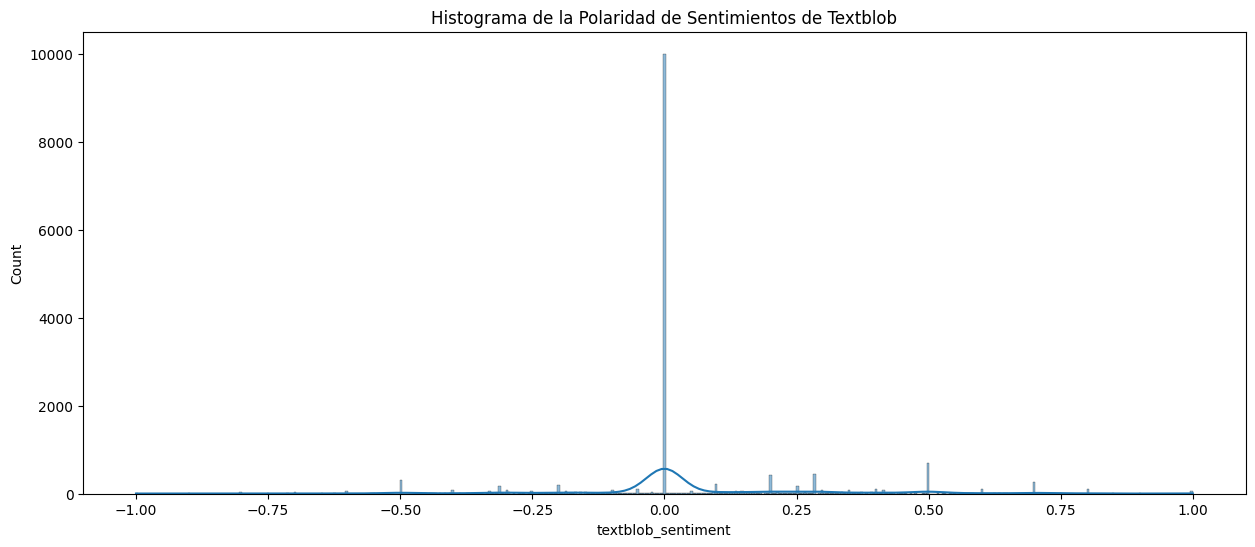

In [24]:
plt.figure(1 , figsize = (15 , 6))
# n = 0
sns.histplot(final_df['textblob_sentiment'] , kde=True)
plt.title('Histograma de la Polaridad de Sentimientos de Textblob')
plt.show()

### Quitar el 90% de los valores neutros para equilibrar el dataset

Con el fin de reequilibrar el dataset, decidimos quitar el 90% de los valores 0, dejamos únicamente el 10%.

In [25]:
# Fitramos las filas que tienen un valor de 0 en 'textblob_sentiment'

# neutros = final_df[final_df['textblob_sentiment'] == 0.0]

neutros = final_df[(final_df['textblob_sentiment'] > -0.20) | (final_df['textblob_sentiment'] < 0.20)]

# Seleccionamos una muestra aletoria del 90% de las filas que tienen 0 y las eliminamos

neutros_a_eliminar = neutros.sample(frac=0.90, random_state=10)

# Eliminamos esas filas del dataset original

final_df_reducido = final_df.drop(neutros_a_eliminar.index)

# Verificamos que el número de neutros se ha reducido adecuadamente

neutros_restantes = final_df_reducido[final_df_reducido['textblob_sentiment'] == 0.0]

print(f"Número de neutros: {len(neutros)}")
print(f"Número de neutros restantes (10%): {len(neutros_restantes)}")

Número de neutros: 16402
Número de neutros restantes (10%): 1019


In [26]:
# final_df_reducido

### Realizar plot de la frecuencia de polaridad de sentimientos por cada personaje principal

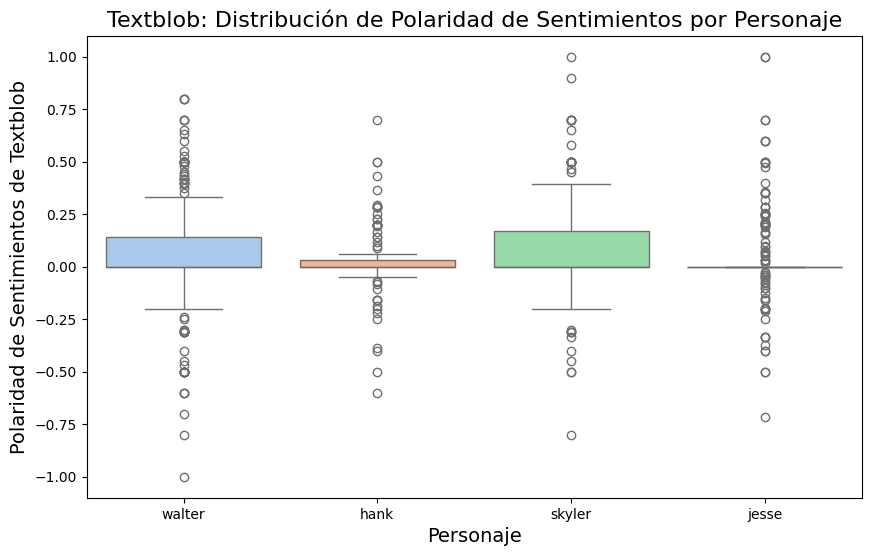

In [27]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Silenciar advertencias
warnings.filterwarnings('ignore')

# Nos enfocamos en los 4 principales personajes de la serie
personajes_seleccionados = ['walter', 'jesse', 'skyler', 'hank']
df_personajes_seleccionados = final_df_reducido[final_df_reducido['Personaje'].isin(personajes_seleccionados)]

# Realizamos plot de la distribución de sentimientos por cada uno de los personajes seleccionados
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_personajes_seleccionados, x='Personaje', y='textblob_sentiment', hue='Personaje', palette='pastel')

# Set title and labels
plt.title('Textblob: Distribución de Polaridad de Sentimientos por Personaje', fontsize=16)
plt.xlabel('Personaje', fontsize=14)  # Cambié el label para que se refiera correctamente al eje
plt.ylabel('Polaridad de Sentimientos de Textblob', fontsize=14)

# Display the plot
plt.show()

### Agrupar sentimientos por la media y la mediana de cada episodio y realizar distintos plots

In [28]:
# Extraemos dos medidas centrales, la media y la mediana, de polaridad de sentimiento de Textblob por cada episodio de cada temporada de todos los personajes

plot_media_episodio = final_df_reducido.groupby(['Temporada', 'Episodio'])['textblob_sentiment'].mean().reset_index()

plot_media_episodio

,Temporada,Episodio,textblob_sentiment
0,1,1,0.03417
1,1,2,0.17445
2,1,3,0.01230
3,1,4,0.00383
4,1,5,0.05940
5,1,6,-0.00050
6,1,7,0.04952
7,2,1,0.05539
8,2,2,0.00222
9,2,3,0.14705


#### Scatterplot de tendencia de la Polaridad de Sentimiento a lo largo de toda la serie para Walter

In [29]:
print(final_df_reducido[final_df_reducido['Personaje'] == 'walter'][['Palabras_clave', 'textblob_sentiment']].head())

          Palabras_clave  textblob_sentiment
26  [eat, veggie, bacon]             0.00000
30    [right, see, home]             0.28571
58           [yeah, see]             0.00000
61               [heavy]            -0.20000
70                [okay]             0.50000


In [30]:
final_df_reducido['Palabras_clave'] = final_df_reducido['Palabras_clave'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

agrupado_walter_sentiment = final_df_reducido[final_df_reducido['Personaje'] == 'walter'].groupby(['Temporada','Episodio'])['textblob_sentiment'].mean()
print(agrupado_walter_sentiment)

Temporada  Episodio
1          1           0.08367
           2           0.23926
           3          -0.01000
           4           0.00000
           5           0.14417
           6           0.01852
           7           0.08780
2          1           0.10255
           2           0.01667
           3           0.23797
           4           0.16413
           5           0.16739
           6           0.24875
           7          -0.07812
           8          -0.08172
           9           0.10162
           10          0.05704
           11          0.03333
           12          0.14694
           13          0.10833
3          1           0.20000
           2           0.09375
           3          -0.16667
           4           0.08333
           5           0.06667
           6           0.16679
           7           0.14078
           8           0.03333
           9           0.05875
           10          0.10010
           11          0.04921
           12      

In [31]:
# Filtramos el df_reducido por un único personaje: Walter White, ya que es su maldad la que debemos estudiar

final_df_reducido_walter = final_df_reducido[final_df_reducido['Personaje'] == 'walter']

final_df_reducido_jesse = final_df_reducido[final_df_reducido['Personaje'] == 'jesse']

# Extraemos dos medidas centrales, la media y la mediana, de polaridad de sentimiento de Textblob por cada episodio de cada temporada de los personajes Walter White, Gus y Jesse

plot_media_episodio_walter = final_df_reducido_walter.groupby(['Temporada', 'Episodio'])['textblob_sentiment'].mean().reset_index()

plot_media_episodio_jesse = final_df_reducido_jesse.groupby(['Temporada', 'Episodio'])['textblob_sentiment'].mean().reset_index()

# plot_media_episodio_walter

plot_mediana_episodio_walter = final_df_reducido_walter.groupby(['Temporada', 'Episodio'])['textblob_sentiment'].mean().reset_index()

plot_mediana_episodio_jesse = final_df_reducido_jesse.groupby(['Temporada', 'Episodio'])['textblob_sentiment'].median().reset_index()

# plot_mediana_episodio_walter

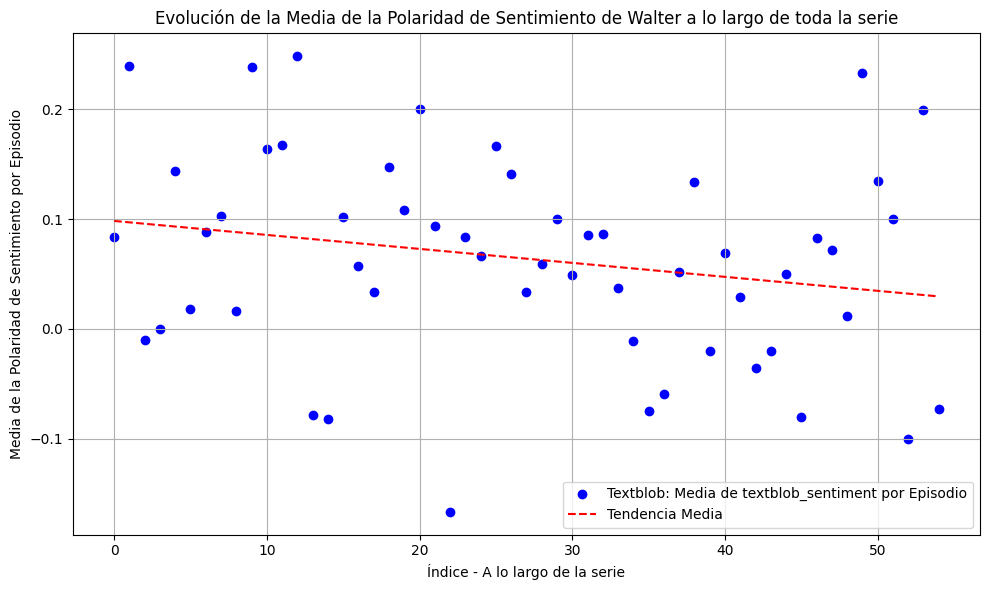

In [32]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Crear la figura para la gráfica
plt.figure(figsize=(10, 6))

# Realizar scatterplot de los valores reales (Media de textblob_sentiment por Episodio de Walter)
plt.scatter(plot_media_episodio_walter.index, plot_media_episodio_walter['textblob_sentiment'], color='blue', label='Textblob: Media de textblob_sentiment por Episodio')

# Ajustar la línea de regresión lineal para la media
X_mean = plot_media_episodio_walter.index.values.reshape(-1, 1)
y_mean = plot_media_episodio_walter['textblob_sentiment']
model_mean = LinearRegression().fit(X_mean, y_mean)
y_pred_mean = model_mean.predict(X_mean)

# Graficar la línea de tendencia de regresión lineal para la media
plt.plot(plot_media_episodio_walter.index, y_pred_mean, color='red', linestyle='--', label='Tendencia Media')

# Añadir títulos y nombres de ejes
plt.title('Evolución de la Media de la Polaridad de Sentimiento de Walter a lo largo de toda la serie')
plt.xlabel('Índice - A lo largo de la serie')
plt.ylabel('Media de la Polaridad de Sentimiento por Episodio')

# Mostrar leyenda y cuadrícula
plt.legend()
plt.grid(True)

# Ajustar el layout y mostrar la gráfica
plt.tight_layout()
plt.show()

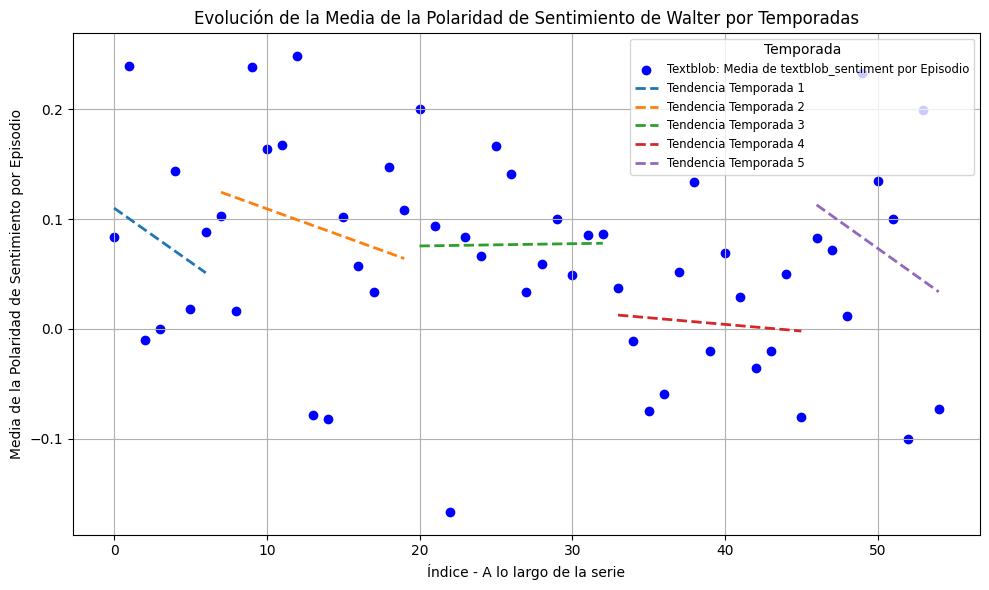

In [33]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Crear la figura para la gráfica
plt.figure(figsize=(10, 6))

# Realizar scatterplot de los valores reales (Media de textblob_sentiment por Episodio de Walter)
plt.scatter(plot_media_episodio_walter.index, plot_media_episodio_walter['textblob_sentiment'], color='blue', label='Textblob: Media de textblob_sentiment por Episodio')

# Iterar por cada temporada para ajustar una línea de tendencia
for temporada in plot_media_episodio_walter['Temporada'].unique():
    # Filtrar los datos por temporada
    data_temp = plot_media_episodio_walter[plot_media_episodio_walter['Temporada'] == temporada]

    # Ajustar la línea de regresión lineal para la media de cada temporada
    X_temp = data_temp.index.values.reshape(-1, 1)
    y_temp = data_temp['textblob_sentiment']
    model_temp = LinearRegression().fit(X_temp, y_temp)
    y_pred_temp = model_temp.predict(X_temp)

    # Graficar la línea de tendencia de regresión lineal para cada temporada
    plt.plot(data_temp.index, y_pred_temp, linestyle='--', linewidth=2, label=f'Tendencia Temporada {temporada}')

# Añadir títulos y nombres de ejes
plt.title('Evolución de la Media de la Polaridad de Sentimiento de Walter por Temporadas')
plt.xlabel('Índice - A lo largo de la serie')
plt.ylabel('Media de la Polaridad de Sentimiento por Episodio')

# Mostrar leyenda y cuadrícula
plt.legend(title='Temporada', loc='upper right', fontsize='small')
plt.grid(True)

# Ajustar el layout y mostrar la gráfica
plt.tight_layout()
plt.show()

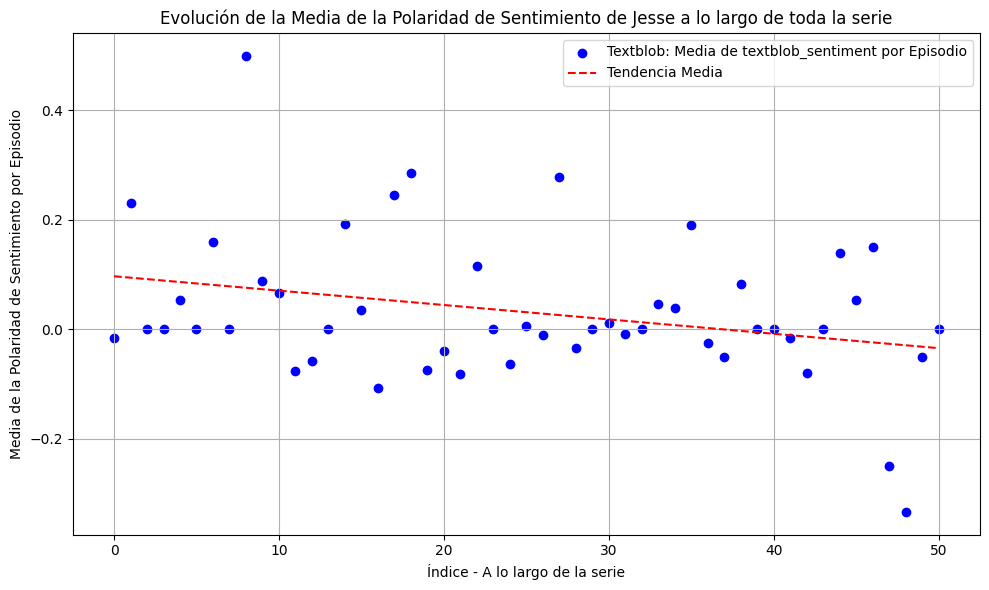

In [34]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Crear la figura para la gráfica
fig, ax = plt.subplots(figsize=(10, 6))

# Realizar scatterplot de los valores reales (Media de textblob_sentiment por Episodio de Jesse)
ax.scatter(plot_media_episodio_jesse.index, plot_media_episodio_jesse['textblob_sentiment'], color='blue', label='Textblob: Media de textblob_sentiment por Episodio')

# Ajustar la línea de regresión lineal para la media
X_mean = plot_media_episodio_jesse.index.values.reshape(-1, 1)
y_mean = plot_media_episodio_jesse['textblob_sentiment']
model_mean = LinearRegression().fit(X_mean, y_mean)
y_pred_mean = model_mean.predict(X_mean)

# Realizar plot de la línea de tendencia para la media
ax.plot(plot_media_episodio_jesse.index, y_pred_mean, color='red', linestyle='--', label='Tendencia Media')

# Añadir títulos y nombres de ejes
ax.set_title('Evolución de la Media de la Polaridad de Sentimiento de Jesse a lo largo de toda la serie')
ax.set_xlabel('Índice - A lo largo de la serie')
ax.set_ylabel('Media de la Polaridad de Sentimiento por Episodio')
ax.legend()
ax.grid(True)

# Ajustar el layout
plt.tight_layout()
plt.show()

## <font color='red'>TEXTBLOB con Custom Lexicon</font>

**Escala:** de -1 (totalmente negativo) a 1 (totalmente positivo), 0 significa neutral (sin carga sentimental).

Se mezcla el Lexicon por defecto con un Lexicon custom realizado por nosotras que recupera las palabras "malas" y les asigna un score negativo. El Textblob las procesará esas palabras con nuestra puntuación en vez de con la de por defecto.

### Importar nuestro custom Lexicon de palabras "malas" como diccionario

In [35]:
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/CAPSTONE/preprocessing_wip_Maite/lexicons/custom_lexicon_for_textblob.xlsx')

# Convertirmos el dataframe en un diccionario para que la función siguiente la pueda procesar
custom_negative_words = dict(zip(df.iloc[:, 0], df.iloc[:, 1]))

print(custom_negative_words)

{'abandoned': -0.8, 'absolutelynone': -0.8, 'abuse': -0.8, 'accident': -0.6, 'addiction': -0.8, 'affair': -0.6, 'afraid': -0.6, 'agitated': -0.6, 'aint': -0.4, 'alcoholic': -0.7, 'alone': -0.6, 'anal': -0.5, 'angrily': -0.8, 'angry': -0.8, 'annoying': -0.6, 'ant': -0.4, 'anxiety': -0.7, 'anxious': -0.7, 'apologize': -0.6, 'arent': -0.5, 'argument': -0.6, 'arrest': -0.9, 'arrested': -0.9, 'arresting': -0.9, 'ash': -0.3, 'ashamed': -0.9, 'assassin': -1.0, 'assault': -1.0, 'asshole': -0.9, 'attack': -0.8, 'awful': -0.9, 'back': -0.2, 'backfire': -0.5, 'backslid': -0.5, 'bad': -0.7, 'badger': -0.5, 'bam': -0.5, 'bandaids': -0.2, 'barely': -0.5, 'bastard': -0.8, 'beaner': -1.0, 'betrayal': -0.7, 'bitch': -0.8, 'blackmailing': -0.9, 'bleeding': -0.6, 'blew': -0.5, 'blood': -0.7, 'bloodshed': -0.9, 'blow': -0.5, 'bomb': -0.6, 'bonehead': -0.7, 'bore': -0.5, 'bored': -0.5, 'bothered': -0.6, 'breakdown': -0.6, 'breakin': -0.5, 'breaking': -0.5, 'broke': -0.7, 'broken': -0.7, 'bullshit': -0.9, '

### Definir la función que obtiene los sentimientos con TEXTBLOB (incluyendo el Lexicon custom) y aplicarla a nuestro dataset

In [36]:
from textblob import TextBlob

# Custom sentiment function
def textblob_custom_sentiment(words):
    # Initialize total sentiment score
    custom_score = 0.0  # Ensure it's a float to handle decimal values
    custom_count = 0

    # Check if any words are in the custom sentiment dictionary
    for word in words:
        word_lower = word.lower()  # Convert word to lowercase

        # Safely get the value from the dictionary, or return None if not found
        sentiment_value = custom_negative_words.get(word_lower)

        # If the word exists in the custom dictionary, add its value
        if sentiment_value is not None:
            custom_score += sentiment_value
            custom_count += 1

    # Calculate average score for custom words if any were found
    if custom_count > 0:
        custom_avg_score = custom_score / custom_count
    else:
        # If no custom words are found, use TextBlob sentiment
        custom_avg_score = TextBlob(' '.join(words)).sentiment.polarity

    return custom_avg_score

In [37]:
final_df.loc[:, 'textblob_custom_sentiment'] = final_df['Palabras_clave'].apply(textblob_custom_sentiment)

# output_path = '/content/drive/Shareddrives/Capstone/preprocessing_wip_Maite/final_df_words_sentiments_custom_sentiments.xlsx'

# final_df.to_excel(output_path, index=False)

### Dibujar el Histograma de los sentimientos extraídos con TEXTBLOB para ver su distribución

Vemos que hay una enorme cantidad de valores neutros (cero o cercanos a cero).

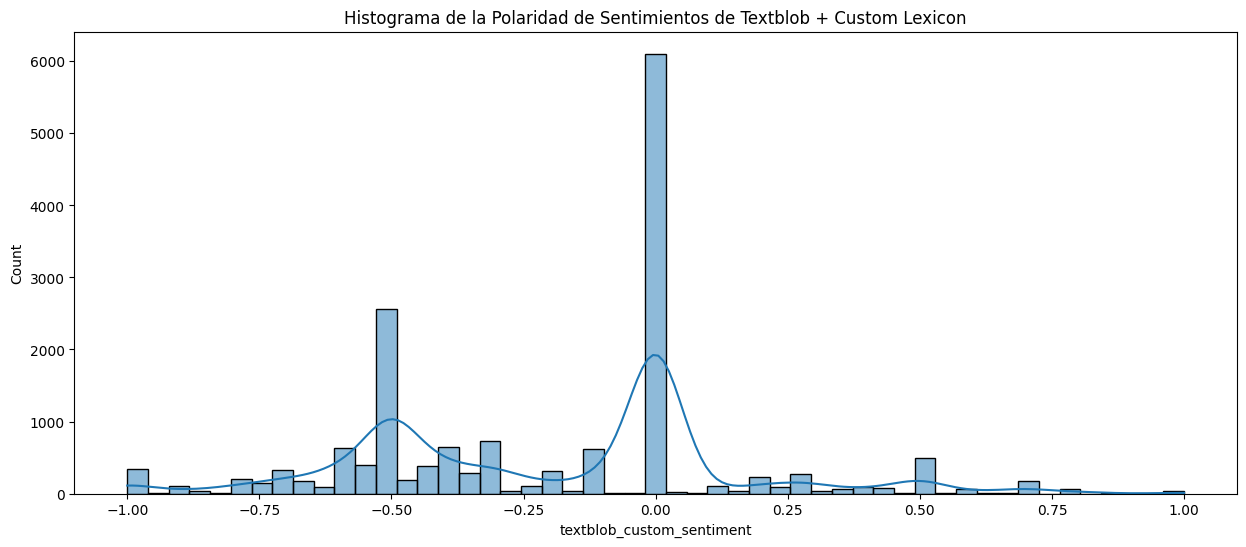

In [38]:
plt.figure(1 , figsize = (15 , 6))
n = 0
sns.histplot(final_df['textblob_custom_sentiment'] , kde=True)
plt.title('Histograma de la Polaridad de Sentimientos de Textblob + Custom Lexicon')
plt.show()

Observamos que al añadir el Lexicon custom con una puntuación mayor para las palabras negativas, la distribución se sesga hacia la parte negativa.

### Quitar el 90% de los valores neutros para equilibrar el dataset

Con el fin de reequilibrar el dataset, decidimos quitar el 90% de los valores 0, dejamos únicamente el 10%.

In [39]:
# Fitramos las filas que tienen un valor de 0 en 'textblob_sentiment'

neutros = final_df[(final_df['textblob_sentiment'] > -0.20) | (final_df['textblob_custom_sentiment'] < 0.20)]

# Seleccionamos una muestra aletoria del 90% de las filas que tienen 0 y las eliminamos

neutros_a_eliminar = neutros.sample(frac=0.9, random_state=10)

# Eliminamos esas filas del dataset original

final_df_reducido = final_df.drop(neutros_a_eliminar.index)

# Verificamos que el número de neutros se ha reducido adecuadamente

neutros_restantes = final_df_reducido[final_df_reducido['textblob_custom_sentiment'] == 0.0]

print(f"Número de neutros originales: {len(neutros)}")
print(f"Número de neutros restantes (10%): {len(neutros_restantes)}")

Número de neutros originales: 16402
Número de neutros restantes (10%): 610


### Realizar plot de la frecuencia de polaridad de sentimientos por cada personaje principal

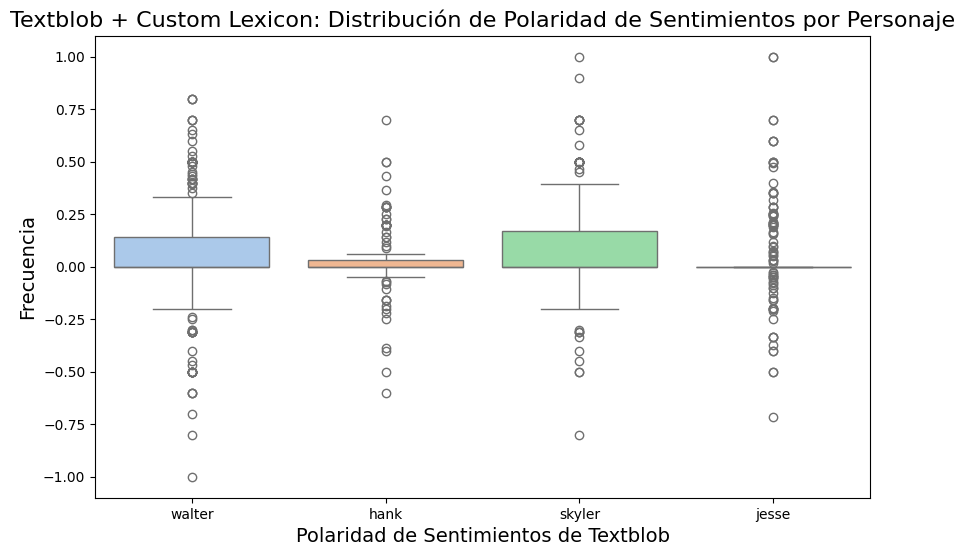

In [40]:
# Nos enfocamos en los 4 principales personajes de la serie

personajes_seleccionados = ['walter', 'jesse', 'skyler', 'hank']
df_personajes_seleccionados = final_df_reducido[final_df_reducido['Personaje'].isin(personajes_seleccionados)]

# Realizamos plot de la distribución de sentimientos por cada unos de los personajes seleccionados Plot sentiment distribution with 'Personaje' as hue

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_personajes_seleccionados, x='Personaje', y='textblob_sentiment', hue='Personaje', palette='pastel')

# Set title and labels
plt.title('Textblob + Custom Lexicon: Distribución de Polaridad de Sentimientos por Personaje', fontsize=16)
plt.xlabel('Polaridad de Sentimientos de Textblob', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Display the plot
plt.show()

Observamos que al añadir el Lexicon custom con una puntuación mayor para las palabras negativas, las medianas se reducen considerablemente.

### Agrupar sentimientos por la media y la mediana de cada episodio y realizar distintos plots

In [41]:
# Extraemos dos medidas centrales, la media y la mediana, de polaridad de sentimiento de Textblob por cada episodio de cada temporada de todos los personajes

plot_media_episodio = final_df_reducido.groupby(['Temporada', 'Episodio'])['textblob_custom_sentiment'].mean().reset_index()

plot_media_episodio

plot_mediana_episodio = final_df_reducido.groupby(['Temporada', 'Episodio'])['textblob_custom_sentiment'].median().reset_index()

plot_mediana_episodio

,Temporada,Episodio,textblob_custom_sentiment
0,1,1,0.00000
1,1,2,0.00000
2,1,3,0.00000
3,1,4,-0.38000
4,1,5,-0.32500
5,1,6,0.00000
6,1,7,-0.28333
7,2,1,-0.41250
8,2,2,-0.47841
9,2,3,-0.45000


#### Scatterplot de tendencia de la Polaridad de Sentimiento a lo largo de toda la serie para Walter

In [42]:
# Filtramos el df_reducido por un único personaje: Walter White, ya que es su maldad la que debemos estudiar

final_df_reducido_walter = final_df_reducido[final_df_reducido['Personaje'] == 'walter']

# Extraemos dos medidas centrales, la media y la mediana, de polaridad de sentimiento de Textblob por cada episodio de cada temporada del personaje Walter White

plot_media_episodio_walter = final_df_reducido_walter.groupby(['Temporada', 'Episodio'])['textblob_custom_sentiment'].mean().reset_index()

plot_media_episodio_walter

plot_mediana_episodio_walter = final_df_reducido_walter.groupby(['Temporada', 'Episodio'])['textblob_custom_sentiment'].median().reset_index()

plot_mediana_episodio_walter

,Temporada,Episodio,textblob_custom_sentiment
0,1,1,0.00000
1,1,2,-0.60000
2,1,3,0.00000
3,1,4,-0.50000
4,1,5,-0.15000
5,1,6,0.00000
6,1,7,-0.13333
7,2,1,-0.45000
8,2,2,-0.37424
9,2,3,-0.40000


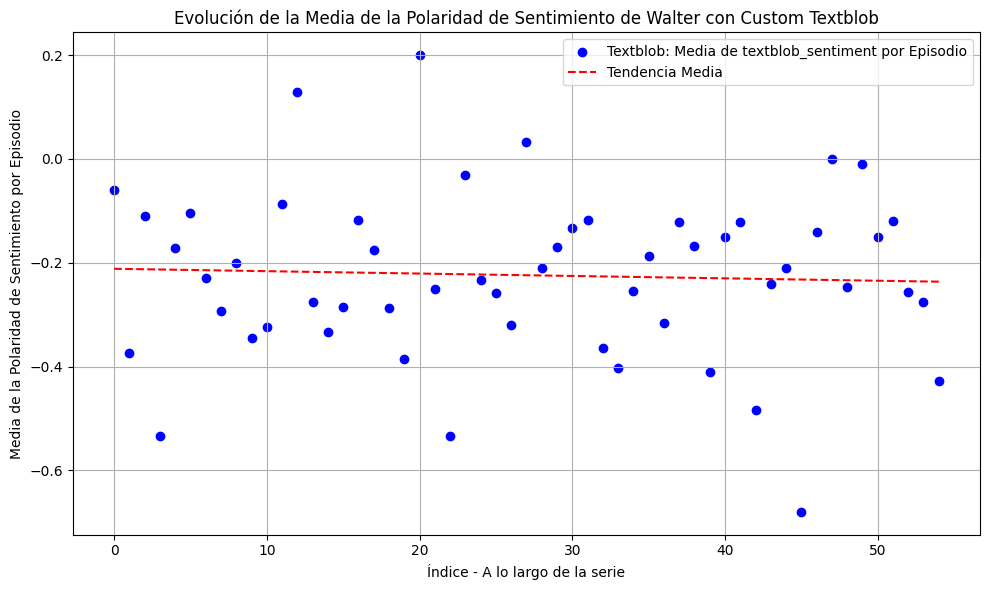

In [43]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Crear la figura para la gráfica
plt.figure(figsize=(10, 6))

# Realizar scatterplot de los valores originales (Media de textblob_sentiment por Episodio de Walter)
plt.scatter(plot_media_episodio_walter.index, plot_media_episodio_walter['textblob_custom_sentiment'], color='blue', label='Textblob: Media de textblob_sentiment por Episodio')

# Ajustar la línea de regresión lineal para la media sin filtrar
X_mean = plot_media_episodio_walter.index.values.reshape(-1, 1)
y_mean = plot_media_episodio_walter['textblob_custom_sentiment']
model_mean = LinearRegression().fit(X_mean, y_mean)
y_pred_mean = model_mean.predict(X_mean)

# Realizar plot de la línea de tendencia para la media sin filtrar
plt.plot(plot_media_episodio_walter.index, y_pred_mean, color='red', linestyle='--', label='Tendencia Media')

# Añadir títulos y nombres de ejes
plt.title('Evolución de la Media de la Polaridad de Sentimiento de Walter con Custom Textblob')
plt.xlabel('Índice - A lo largo de la serie')
plt.ylabel('Media de la Polaridad de Sentimiento por Episodio')

# Mostrar leyenda y cuadrícula
plt.legend()
plt.grid(True)

# Ajustar el layout y mostrar la gráfica
plt.tight_layout()
plt.show()

## <font color='red'>VADER (Valence Aware Dictionary and sEntiment Reasoner)</font>

Diseñado específicamente para textos de redes sociales, funciona bien con textos cortos e informales, aunque no detecta bien el sarcasmo ni la ironía. Toma en cuenta los signos de puntuación y las mayúsculas, así como las palabras colindantes que pudieran modificar el significado del conjunto. Tampoco entiende bien las negaciones: "not bad" sería clasificado como malo por Vader.

**Escala:**
*    De 0 a 0.05: Neutral
*    0.05 < x < 1: Positivo o Negativo (los valores se ubican en columnas distitas)
*    COMPOUND: de -1 a 1. Es una puntuación de sentimiento generalizado.

**Mide el Sentimiento en el caso del Positivo, Negativo y Neutral, y la Polaridad en el caso del Compound.**

### Instalar e importar la librería, definir la función que obtiene los sentimientos con VADER y aplicarla a nuestro dataset

In [44]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.8 MB/s eta 0:00:00


In [45]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def vader_get_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()

    # If 'text' is a list of words, join them into a single string
    if isinstance(text, list):
        text = ' '.join(text)

    # Call the polarity_scores method on the text
    return analyzer.polarity_scores(text)

In [46]:
# Le pasamos la función previamente definida a nuestro dataset (Atencion: Puede tardar un poco porque le estamos pasando la columna Texto (sin preprocesar), en vez de la columna Palabras_clave (preprocesada) ya que Vader tiene en cuenta también los intensificadores, las negaciones y las puntuaciones).

final_df['Vader_sentimiento'] = final_df['Texto'].apply(vader_get_sentiment)

# output_path = '/content/drive/MyDrive/CAPSTONE/preprocessing_wip_Maite/final_df_words_sentiments_customsentiments_vader.xlsx'

# final_df.to_excel(output_path, index=False)

#### Separar los resultados de Vader en diferentes columnas: score negativo, positivo, neutro y compound.

In [47]:
# Extract the 'negative' values
final_df['vader_negative'] = final_df['Vader_sentimiento'].apply(lambda x: x['neg'])

# final_df['vader_negative']

In [48]:
# Extract the 'neutral' values
final_df['vader_positive'] = final_df['Vader_sentimiento'].apply(lambda x: x['pos'])

# final_df['vader_positive']

In [49]:
# Extract the 'positive' values
final_df['vader_neutral'] = final_df['Vader_sentimiento'].apply(lambda x: x['neu'])

# final_df['vader_neutral']

In [50]:
# Extract the 'compound' values
final_df['vader_compound'] = final_df['Vader_sentimiento'].apply(lambda x: x['compound'])

# final_df['vader_compound']

In [51]:
output_path = '/content/drive/MyDrive/CAPSTONE/preprocessing_wip_Maite/final_df_words_sentiments_customsentiments_vaderseparados.xlsx'

final_df.to_excel(output_path, index=False)

### Dibujar el Histograma de los sentimientos extraídos con VADER para ver su distribución

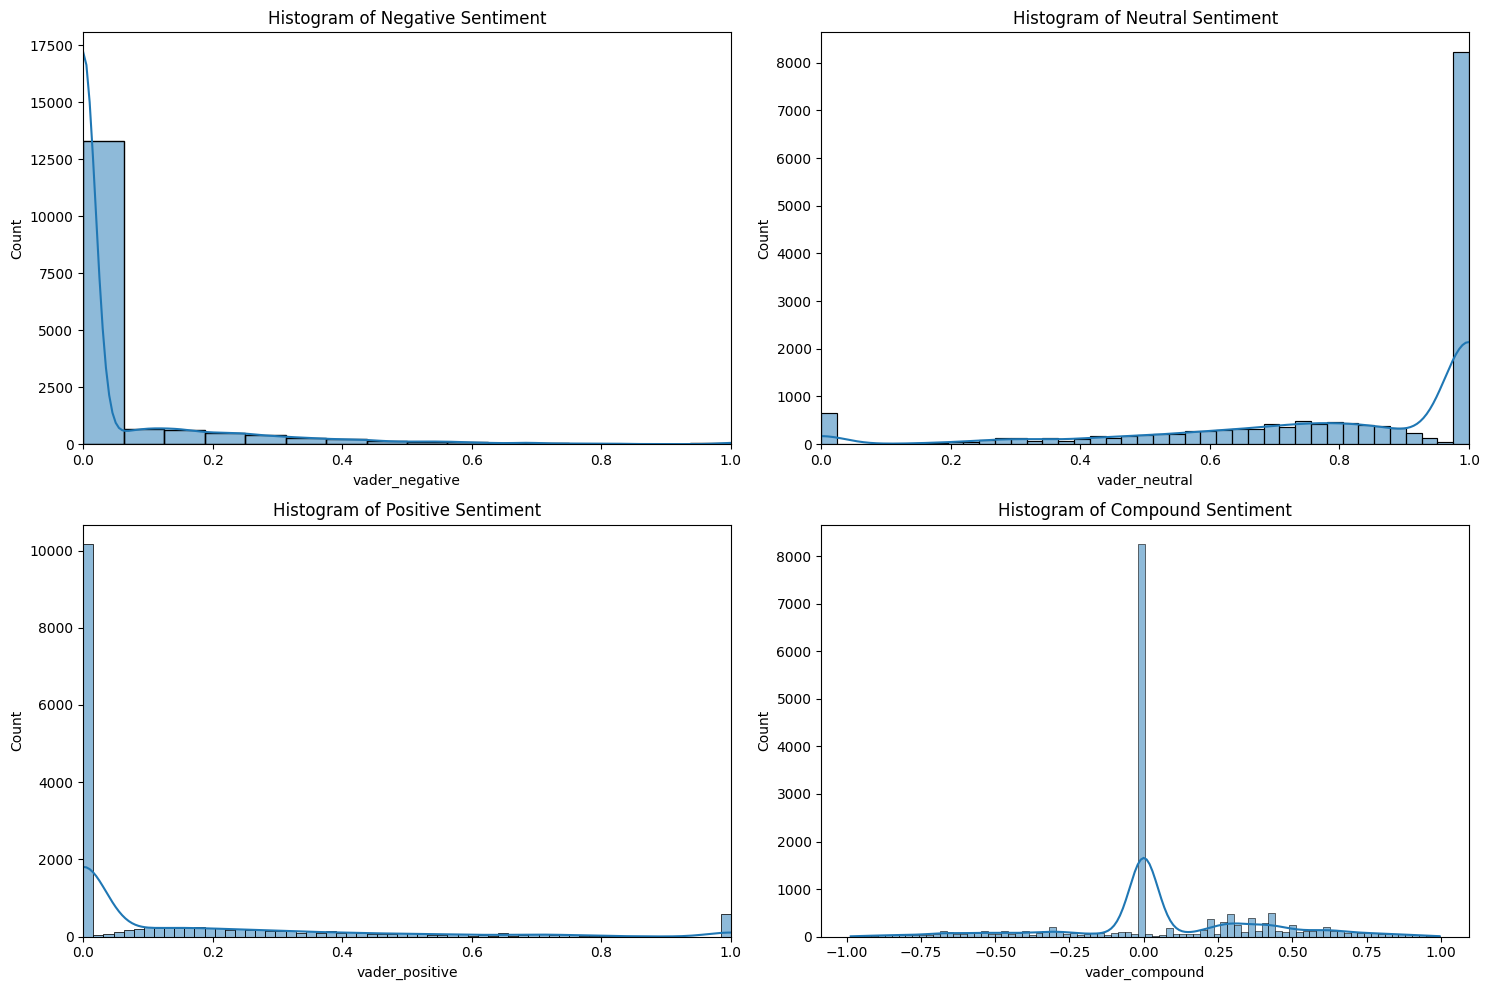

In [52]:
# Set up the 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot for 'neg'
sns.histplot(final_df['vader_negative'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Histogram of Negative Sentiment')
axes[0, 0].set_xlim(0, 1)

# Plot for 'neu'
sns.histplot(final_df['vader_neutral'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Histogram of Neutral Sentiment')
axes[0, 1].set_xlim(0, 1)

# Plot for 'pos'
sns.histplot(final_df['vader_positive'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Histogram of Positive Sentiment')
axes[1, 0].set_xlim(0, 1)

# Plot for 'compound'
sns.histplot(final_df['vader_compound'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Histogram of Compound Sentiment')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Quitar el 90% de los valores neutros para equilibrar el dataset

In [53]:
# Filtramos las filas que tienen un valor de 0 en cada variable de Vader
variables = ['vader_neutral', 'vader_compound']
neutros_dict = {}  # Para almacenar el DataFrame de neutros de cada variable

for var in variables:
    neutros = final_df[(final_df[var] >= -0.02) & (final_df[var] <= 0.02)]

    # Seleccionamos una muestra aleatoria del 90% de las filas que tienen 0 y las eliminamos
    neutros_a_eliminar = neutros.sample(frac=0.9, random_state=10)

    # Eliminamos esas filas del dataset original
    final_df_reducido = final_df.drop(neutros_a_eliminar.index)

    # Guardar el número de neutros restantes para verificación
    neutros_restantes = final_df_reducido[final_df_reducido[var] == 0.0]
    neutros_dict[var] = {
        "original": len(neutros),
        "remaining": len(neutros_restantes)
    }

# Verificamos que el número de neutros se ha reducido adecuadamente

# Verificamos que el número de neutros se ha reducido adecuadamente
for var, counts in neutros_dict.items():
    print(f"Número de neutros originales en {var}: {counts['original']}")
    print(f"Número de neutros restantes en {var} (10%): {counts['remaining']}")

Número de neutros originales en vader_neutral: 646
Número de neutros restantes en vader_neutral (10%): 65
Número de neutros originales en vader_compound: 8264
Número de neutros restantes en vader_compound (10%): 823


### Agrupar sentimientos por la media y la mediana de cada episodio y realizar distintos plots

In [54]:
vader_vars = ['vader_compound', 'vader_negative', 'vader_positive', 'vader_neutral']

In [55]:
vader_media_episodio = {}

for var in vader_vars:
    vader_media_episodio[var] = final_df.groupby(['Temporada', 'Episodio'])[var].mean().reset_index()

for var in vader_vars:
    print(f"\nGrouped mean for {var}:\n", vader_media_episodio[var])


Grouped mean for vader_compound:
     Temporada  Episodio  vader_compound
0           1         1         0.07389
1           1         2         0.07892
2           1         3        -0.00288
3           1         4         0.11522
4           1         5         0.12377
5           1         6         0.08226
6           1         7         0.10288
7           2         1         0.02273
8           2         2         0.04197
9           2         3         0.07894
10          2         4         0.10589
11          2         5         0.10085
12          2         6         0.10638
13          2         7         0.05870
14          2         8         0.01898
15          2         9         0.02570
16          2        10         0.10571
17          2        11         0.06333
18          2        12         0.07216
19          2        13         0.11416
20          3         1         0.14974
21          3         2         0.11683
22          3         3         0.13036
23   

#### Scatterplot de tendencia de la Polaridad de Sentimiento a lo largo de toda la serie para Walter

In [56]:
final_df_reducido_walter = final_df[final_df['Personaje'] == 'walter']

vader_media_episodio_walter = {}

for var in vader_vars:
    vader_media_episodio_walter[var] = final_df_reducido_walter.groupby(['Temporada', 'Episodio'])[var].mean().reset_index()

for var in vader_vars:
    print(f"\nGrouped mean for {var}:\n", vader_media_episodio_walter[var])


Grouped mean for vader_compound:
     Temporada  Episodio  vader_compound
0           1         1         0.09020
1           1         2         0.12063
2           1         3        -0.03603
3           1         4         0.03893
4           1         5         0.23265
5           1         6         0.14166
6           1         7         0.11828
7           2         1         0.02941
8           2         2        -0.05861
9           2         3         0.10291
10          2         4         0.07836
11          2         5         0.07757
12          2         6         0.26496
13          2         7         0.02797
14          2         8        -0.03753
15          2         9         0.00847
16          2        10         0.16242
17          2        11         0.10281
18          2        12         0.10490
19          2        13         0.14601
20          3         1         0.20198
21          3         2         0.16813
22          3         3         0.18868
23   

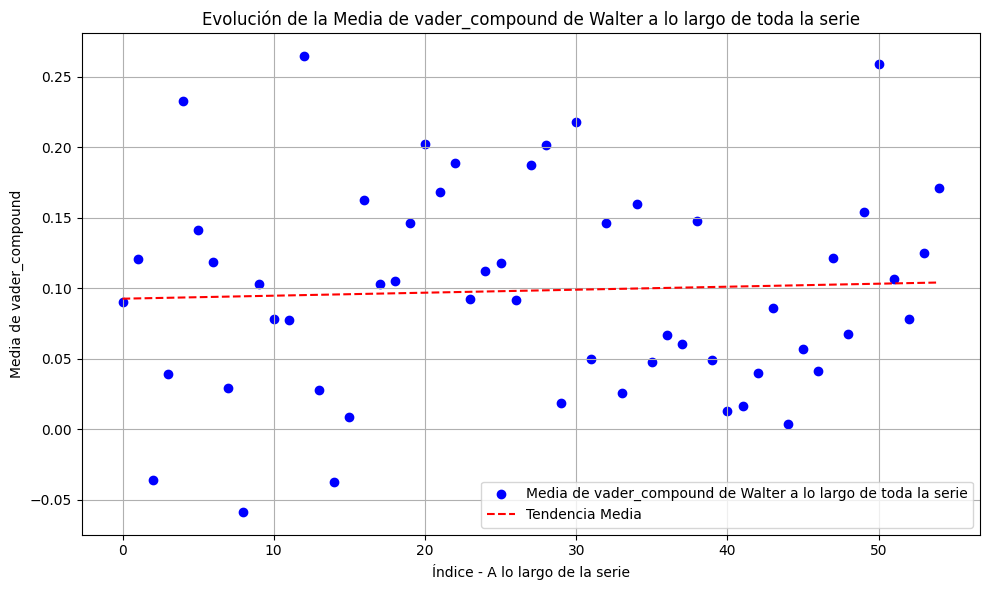

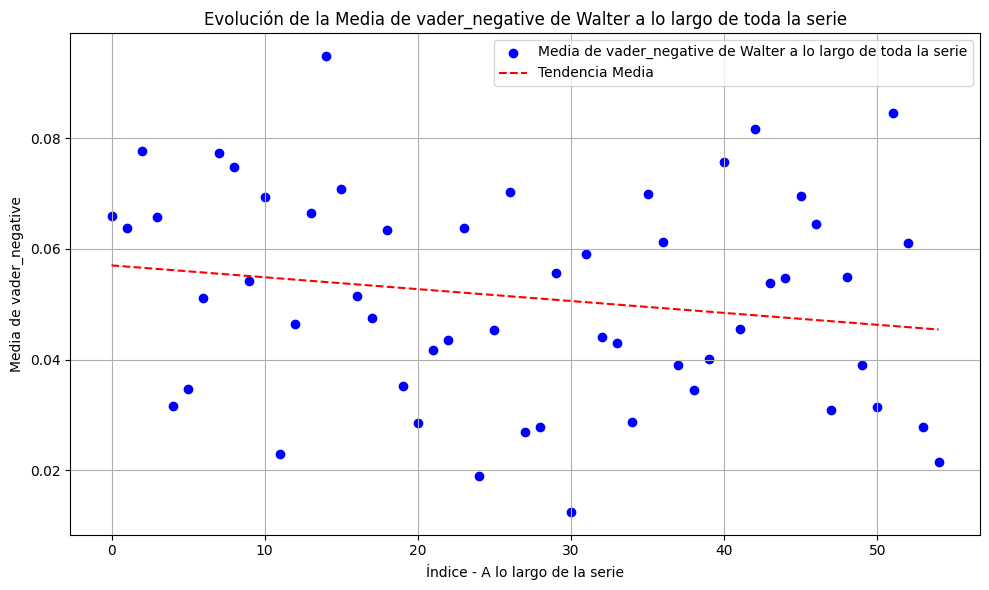

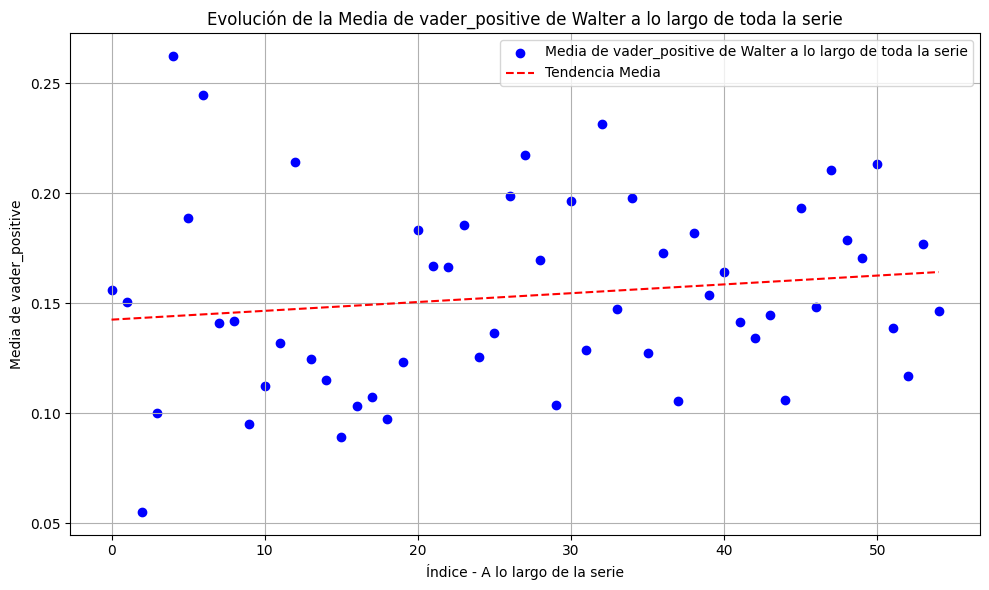

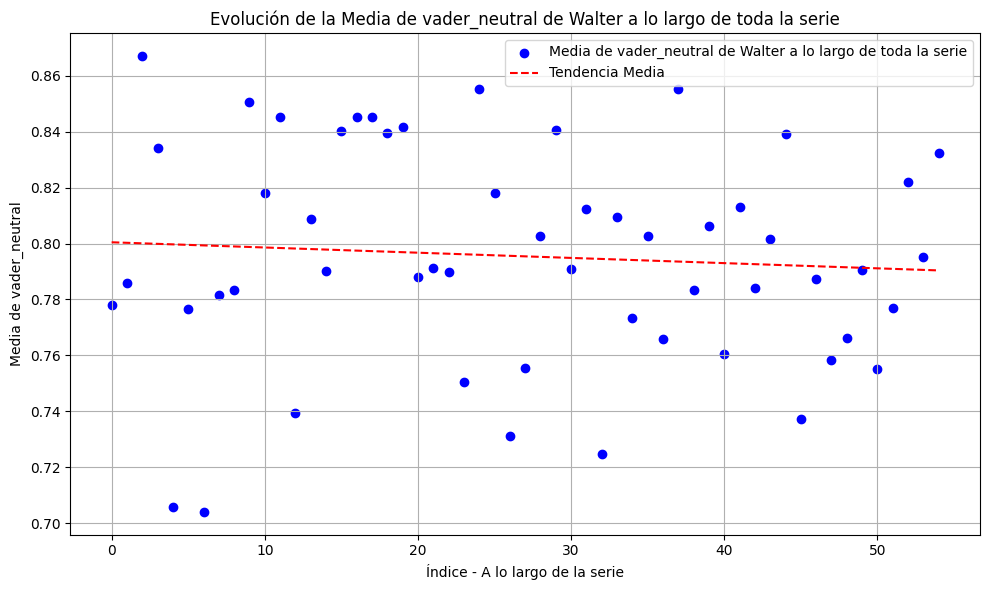

In [57]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Iterar sobre las variables de Vader
for var in vader_vars:
    # Suponiendo que cada var tiene un DataFrame con datos de 'media'
    plot_media_episodio_walter = vader_media_episodio_walter[var]

    # Crear la figura para el gráfico
    plt.figure(figsize=(10, 6))

    # Graficar los puntos de la media
    plt.scatter(plot_media_episodio_walter.index, plot_media_episodio_walter[var], color='blue',
                label='Media de ' + var + ' de Walter a lo largo de toda la serie')

    # Ajustar una línea de regresión lineal para la media
    X_mean = plot_media_episodio_walter.index.values.reshape(-1, 1)  # Cambiar la forma para sklearn
    y_mean = plot_media_episodio_walter[var].values
    model_mean = LinearRegression().fit(X_mean, y_mean)
    y_pred_mean = model_mean.predict(X_mean)

    # Graficar la línea de tendencia para la media
    plt.plot(plot_media_episodio_walter.index, y_pred_mean, color='red', linestyle='--', label='Tendencia Media')

    # Títulos y etiquetas
    plt.title(f'Evolución de la Media de {var} de Walter a lo largo de toda la serie')
    plt.xlabel('Índice - A lo largo de la serie')
    plt.ylabel(f'Media de {var}')
    plt.legend()
    plt.grid(True)

    # Mostrar la gráfica
    plt.tight_layout()
    plt.show()

## <font color='red'>SENTIWORDNET</font>

A partir de la base de datos WordNet, este léxico asigna puntuaciones de sentimiento positivas, negativas y neutras a los synsets (grupos de palabras con el mismo significado). Se utiliza en minería de opiniones, por lo que en principio no está adaptado para entender diálogos entre personas.

**Escala:**

### Instalar e importar las librerías, definir la función que obtiene los sentimientos con SENTIWORDNET y aplicarla a nuestro dataset

In [58]:
# Instalar o reinstalar las librerías necesarias

import nltk
nltk.download('sentiwordnet')
nltk.download('wordnet')

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [59]:
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize

def sentiwordnet_get_sentiment(text):
    # If the input is a list of words, join them into a single string
    if isinstance(text, list):
        text = ' '.join(text)

    # Tokenize the input text
    words = word_tokenize(text)

    # Initialize scores
    pos_score = 0
    neg_score = 0
    num_words = 0

    # Iterate through each word in the text
    for word in words:
        # Get the SentiWordNet synsets
        synsets = list(swn.senti_synsets(word))

        # Calculate average sentiment scores for the word
        if synsets:
            # Get the first synset (you can choose a different strategy)
            synset = synsets[0]
            pos_score += synset.pos_score()
            neg_score += synset.neg_score()
            num_words += 1

    # Calculate average scores
    if num_words > 0:
        pos_score /= num_words
        neg_score /= num_words

    return {'positive': pos_score, 'negative': neg_score, 'compound': pos_score - neg_score}

In [60]:
# apply sentiment analysis
final_df['Sentiwordnet'] = final_df['Palabras_clave'].apply(sentiwordnet_get_sentiment)

output_path = '/content/drive/MyDrive/CAPSTONE/preprocessing_wip_Maite/final_df_words_sentiments_customsentiments_vader_sentiwordnet.xlsx'

final_df.to_excel(output_path, index=False)

#### Separar los resultados de Sentiwordnet en diferentes columnas: score negativo, positivo y compound (no existen el scoring neutral).

In [61]:
# Extraer los scorings negativos

final_df['sentiwordnet_negative'] = final_df['Sentiwordnet'].apply(lambda x: x['negative'])

# final_df['sentiwordnet_negative']

In [62]:
# Extraer los scorings positivos

final_df['sentiwordnet_positive'] = final_df['Sentiwordnet'].apply(lambda x: x['positive'])

# final_df['sentiwordnet_positive']

In [63]:
# Extraer los scorings compound (compuestos)

final_df['sentiwordnet_compound'] = final_df['Sentiwordnet'].apply(lambda x: x['compound'])

# final_df['sentiwordnet_compound']

In [64]:
output_path = '/content/drive/MyDrive/CAPSTONE/preprocessing_wip_Maite/final_df_words_sentiments_customsentiments_vaderseparados_sentiwordnetseparados.xlsx'

final_df.to_excel(output_path, index=False)

### Dibujar el Histograma de los sentimientos extraídos con SENTIWORDNET para ver su distribución
Vemos que hay una enorme cantidad de valores neutros (cero o cercanos a cero) en todos los scorings (negativo, positivo, neutro y compound).

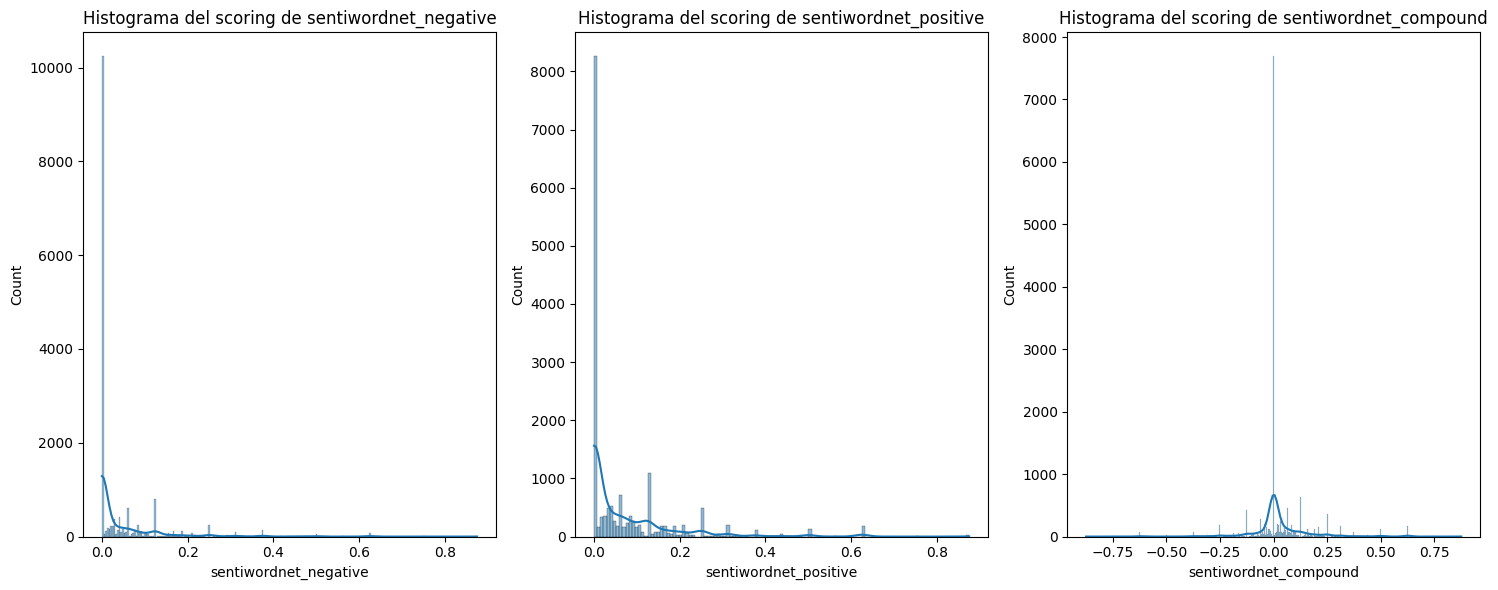

In [65]:
# Set up the 2x2 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Realizar plot de sentiwordnet_negative
sns.histplot(final_df['sentiwordnet_negative'], kde=True, ax=axes[0])
axes[0].set_title('Histograma del scoring de sentiwordnet_negative')

# Realizar plot de sentiwordnet_positive
sns.histplot(final_df['sentiwordnet_positive'], kde=True, ax=axes[1])
axes[1].set_title('Histograma del scoring de sentiwordnet_positive')

# Realizar plot de sentiwordnet_compound
sns.histplot(final_df['sentiwordnet_compound'], kde=True, ax=axes[2])
axes[2].set_title('Histograma del scoring de sentiwordnet_compound')

plt.tight_layout()
plt.show()

Quitamos, como venimos haciendo hasta ahora en este tipo de casos, el 90% de los valores neutros con el fin de reequilibrar el dataset.

### Quitar el 90% de los valores neutros para equilibrar el dataset

Con el fin de reequilibrar el dataset, decidimos quitar el 90% de los valores 0, dejamos únicamente el 10%. Realizaremos esta operación en los 4 scorings: negativo, positivo, neutro y compound.

In [66]:
sentiwordnet_vars = ['sentiwordnet_negative', 'sentiwordnet_positive', 'sentiwordnet_compound']

In [67]:
# Filtramos las filas que tienen un valor en torno a cero en cada variable de Sentiwordnet

neutros_dict = {}  # Para almacenar el DataFrame de neutros de cada variable

for var in sentiwordnet_vars:
    neutros = final_df[(final_df[var] >= -0.0) & (final_df[var] <= 0.0)]
    # neutros = final_df[(final_df[var] == 0.0)]

    # Seleccionamos una muestra aleatoria del 90% de las filas que están en el rango definido más arriba y las eliminamos
    neutros_a_eliminar = neutros.sample(frac=0.8, random_state=10)

    # Eliminamos esas filas del dataset original
    final_df_reducido = final_df.drop(neutros_a_eliminar.index)

    # Guardar el número de neutros restantes para verificación
    neutros_restantes = final_df_reducido[final_df_reducido[var] == 0.0]
    neutros_dict[var] = {
        "original": len(neutros),
        "remaining": len(neutros_restantes)
    }

# Verificamos que el número de neutros se ha reducido adecuadamente

# Verificamos que el número de neutros se ha reducido adecuadamente
for var, counts in neutros_dict.items():
    print(f"Número de {var} originales en {var}: {counts['original']}")
    print(f"Número de {var} restantes en {var} (10%): {counts['remaining']}")

Número de sentiwordnet_negative originales en sentiwordnet_negative: 10236
Número de sentiwordnet_negative restantes en sentiwordnet_negative (10%): 2047
Número de sentiwordnet_positive originales en sentiwordnet_positive: 8247
Número de sentiwordnet_positive restantes en sentiwordnet_positive (10%): 1649
Número de sentiwordnet_compound originales en sentiwordnet_compound: 7690
Número de sentiwordnet_compound restantes en sentiwordnet_compound (10%): 1538


### Realizar plot de la frecuencia de polaridad de sentimientos por cada personaje principal

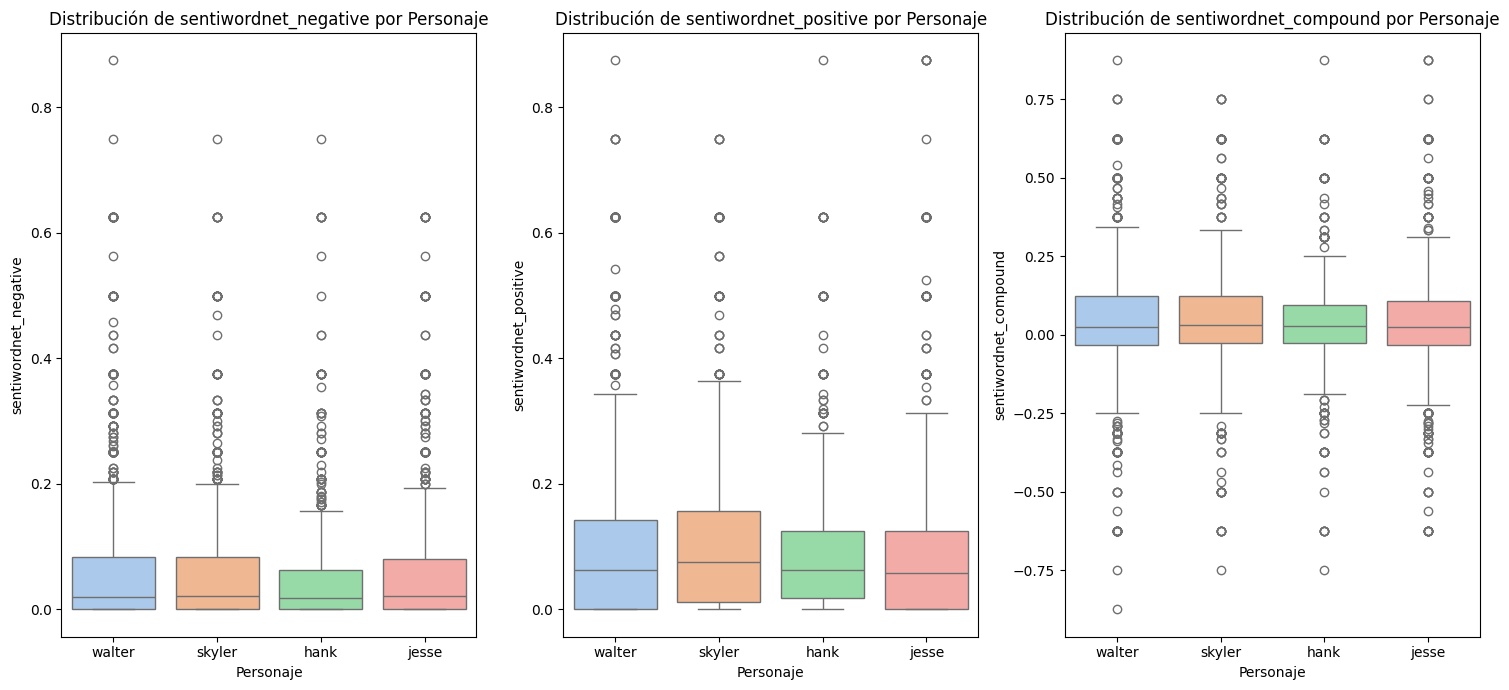

In [68]:
personajes_seleccionados = ['walter', 'jesse', 'skyler', 'hank']
df_personajes_seleccionados = final_df_reducido[final_df_reducido['Personaje'].isin(personajes_seleccionados)]

# Set up the 2x2 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15,7))

# Realizar plot para sentiwordnet_negative
sns.boxplot(data=df_personajes_seleccionados, x='Personaje', y='sentiwordnet_negative', hue='Personaje', palette='pastel', ax=axes[0])
axes[0].set_title('Distribución de sentiwordnet_negative por Personaje')

# Realizar plot para sentiwordnet_positive
sns.boxplot(data=df_personajes_seleccionados, x='Personaje', y='sentiwordnet_positive', hue='Personaje', palette='pastel', ax=axes[1])
axes[1].set_title('Distribución de sentiwordnet_positive por Personaje')

# Realizar plot para sentiwordnet_compound
sns.boxplot(data=df_personajes_seleccionados, x='Personaje', y='sentiwordnet_compound', hue='Personaje', palette='pastel', ax=axes[2])
axes[2].set_title('Distribución de sentiwordnet_compound por Personaje')

plt.tight_layout()
plt.show()

### Agrupar sentimientos por la media y la mediana de cada episodio y realizar distintos plots

In [69]:
sentiwordnet_media_episodio = {}

for var in sentiwordnet_vars:
    sentiwordnet_media_episodio[var] = final_df_reducido.groupby(['Temporada', 'Episodio'])[var].mean().reset_index()

for var in sentiwordnet_vars:
    print(f"\nGrouped mean for {var}:\n", sentiwordnet_media_episodio[var])


Grouped mean for sentiwordnet_negative:
     Temporada  Episodio  sentiwordnet_negative
0           1         1                0.05254
1           1         2                0.04956
2           1         3                0.06012
3           1         4                0.06111
4           1         5                0.06110
5           1         6                0.06208
6           1         7                0.04720
7           2         1                0.05834
8           2         2                0.05714
9           2         3                0.05822
10          2         4                0.05819
11          2         5                0.08392
12          2         6                0.06341
13          2         7                0.08328
14          2         8                0.05996
15          2         9                0.05898
16          2        10                0.06984
17          2        11                0.05485
18          2        12                0.05571
19          2     

#### Scatterplot de tendencia de la Polaridad de Sentimiento a lo largo de toda la serie para Walter

In [70]:
final_df_reducido_walter = final_df_reducido[final_df_reducido['Personaje'] == 'walter']

sentiwordnet_media_episodio_walter = {}

for var in sentiwordnet_vars:
    sentiwordnet_media_episodio_walter[var] = final_df_reducido_walter.groupby(['Temporada', 'Episodio'])[var].mean().reset_index()

for var in sentiwordnet_vars:
    print(f"\nGrouped mean for {var}:\n", sentiwordnet_media_episodio_walter[var])


Grouped mean for sentiwordnet_negative:
     Temporada  Episodio  sentiwordnet_negative
0           1         1                0.05151
1           1         2                0.05600
2           1         3                0.07868
3           1         4                0.08002
4           1         5                0.06447
5           1         6                0.05958
6           1         7                0.04843
7           2         1                0.05404
8           2         2                0.05578
9           2         3                0.06393
10          2         4                0.05919
11          2         5                0.07389
12          2         6                0.06582
13          2         7                0.04232
14          2         8                0.07670
15          2         9                0.05872
16          2        10                0.07789
17          2        11                0.06730
18          2        12                0.07391
19          2     

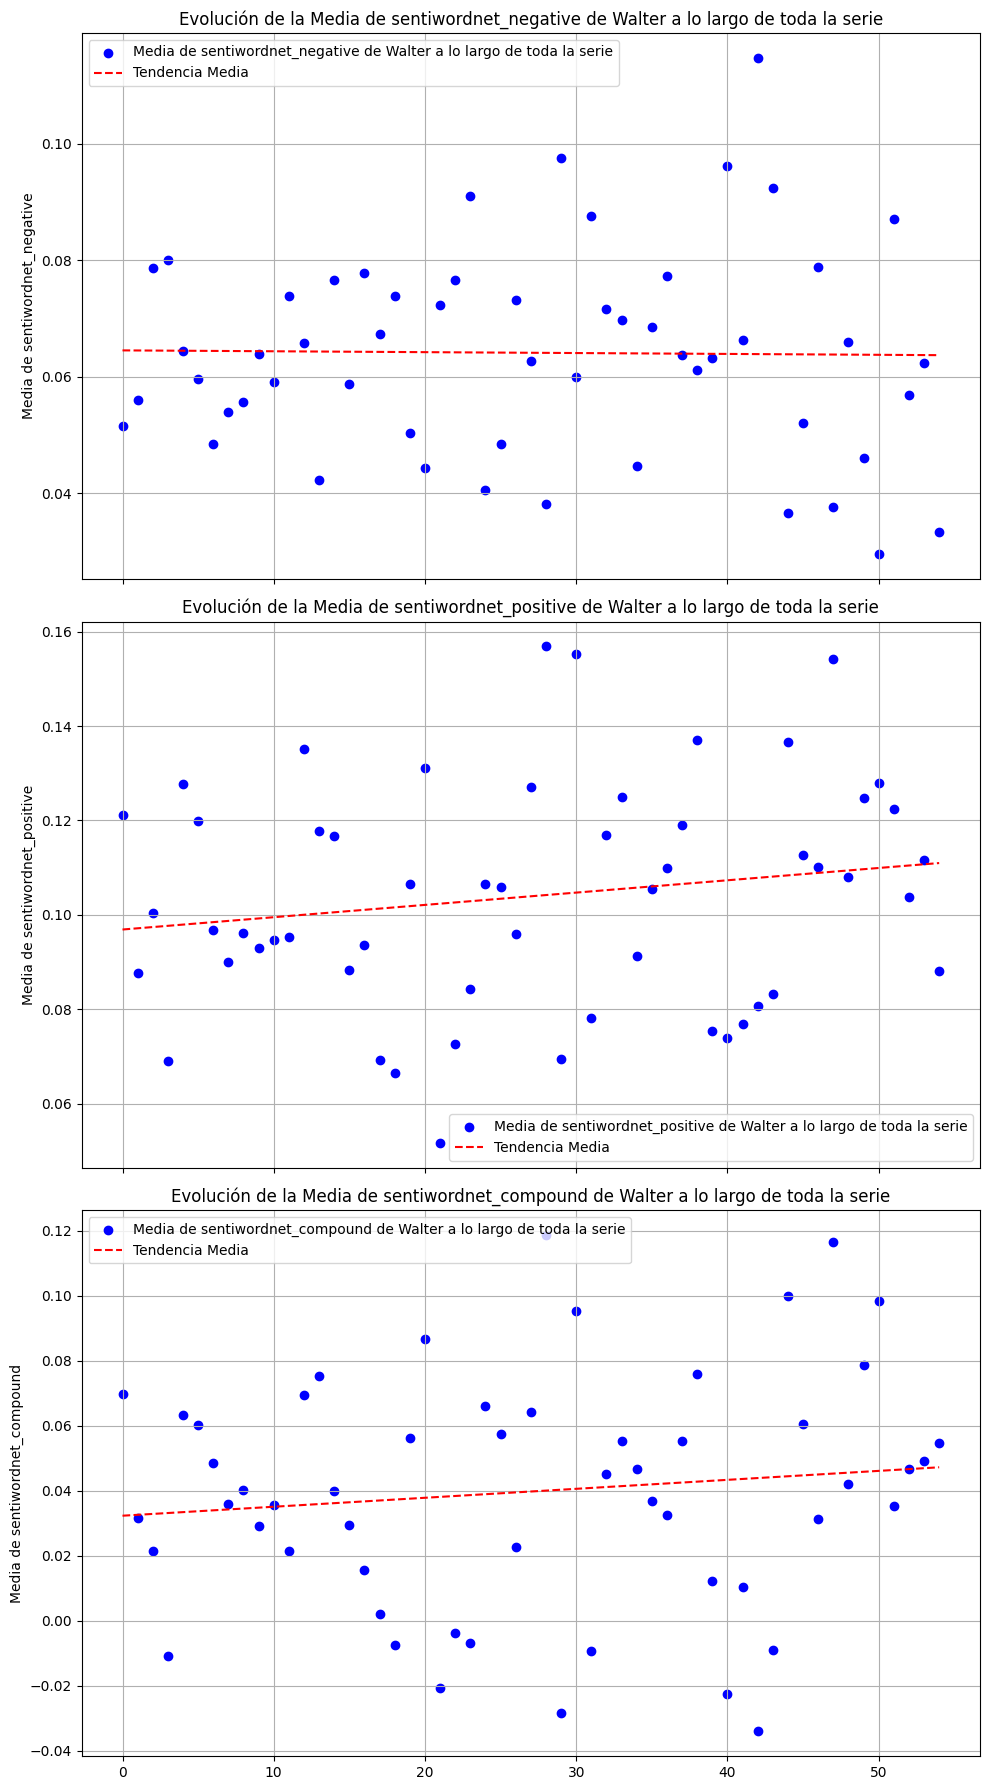

In [71]:
fig, axs = plt.subplots(len(sentiwordnet_vars), 1, figsize=(10, 6 * len(sentiwordnet_vars)), sharex=True)

for i, var in enumerate(sentiwordnet_vars):

    # Filtrar los datos por la media
    plot_media_episodio_walter = sentiwordnet_media_episodio_walter[var]

    # Scatter plot de la media
    axs[i].scatter(plot_media_episodio_walter.index, plot_media_episodio_walter[var], color='blue', label='Media de ' + var + ' de Walter a lo largo de toda la serie')

    # Ajustar la línea de regresión lineal para la media
    X_mean = plot_media_episodio_walter.index.values.reshape(-1, 1)  # Reshape for sklearn
    y_mean = plot_media_episodio_walter[var].values  # Acceder correctamente a los valores
    model_mean = LinearRegression().fit(X_mean, y_mean)
    y_pred_mean = model_mean.predict(X_mean)

    # Graficar la línea de tendencia de la media
    axs[i].plot(plot_media_episodio_walter.index, y_pred_mean, color='red', linestyle='--', label='Tendencia Media')

    # Títulos y etiquetas
    axs[i].set_title(f'Evolución de la Media de {var} de Walter a lo largo de toda la serie')
    axs[i].set_ylabel(f'Media de {var}')
    axs[i].legend()
    axs[i].grid(True)

# Ajustar el layout
plt.tight_layout()
plt.show()

## <font color='red'>NRC</font>

El Léxico de Emociones del NRC es una lista de palabras inglesas y sus asociaciones con ocho emociones básicas (ira, miedo, anticipación, confianza, sorpresa, tristeza, alegría y asco) y dos sentimientos (negativo y positivo).

Cada palabra de este lexicon puede pertenecer a una categoría o a varias. Por ejemplo, la palabra abandono puntuará en las emociones tristeza y miedo y en el sentimiento negativo.

**Escala:** Suma un punto a las categorías a las que pertenece una palabra cada vez que la encuentra.

**Mide el Sentimiento.**

### Importar Lexicon NRC Emotion Word-Level v0.92

In [72]:
nrc_lexicon_path = '/content/drive/MyDrive/CAPSTONE/preprocessing_wip_Maite/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'

### Crear df del Lexicon

In [73]:
nrc_df = pd.read_csv(nrc_lexicon_path, names=['word', 'emotion', 'association'], sep='\t')
nrc_df = nrc_df.pivot(index='word', columns='emotion', values='association').reset_index()

nrc_df.head(5)

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,NaN,0,0,0,0,0,0,0,0,0,0
1,aback,0,0,0,0,0,0,0,0,0,0
2,abacus,0,0,0,0,0,0,0,0,0,1
3,abandon,0,0,0,1,0,1,0,1,0,0
4,abandoned,1,0,0,1,0,1,0,1,0,0


### Convertir Lexicon en diccionario

In [74]:
# lexicon to dict

nrc_dict = nrc_df.set_index('word').T.to_dict('list')

# nrc_dict

### Definir la función que atribuye intensidad a las emociones/sentimientos gracias al Lexicon importado y aplicarla a nuestro dataset

In [75]:
# emotion intensity
def get_emotion_intensity(text):
    emotion_intensity = {emotion: 0 for emotion in nrc_df.columns if emotion != 'word'}
    for word in text:
        if word in nrc_dict:
            for emotion, score in zip(nrc_df.columns[1:], nrc_dict[word]):
                emotion_intensity[emotion] += score
    return emotion_intensity

# apply emotion scoring
final_df['NRC_emotion_intensity'] = final_df['Palabras_clave'].apply(get_emotion_intensity)

final_df.shape

(16402, 19)

#### Separar los resultados de NRC en diferentes columnas: anger, anticipation, disgust, fear, joy, negative, positive, sadness, suprise, trust.

In [76]:
# Extraer las distintas emociones con sus scores correspondientes

emotions = nrc_df.columns[1:]
for emotion in emotions:
    final_df['NRC_emotion_intensity ' + emotion] = final_df['NRC_emotion_intensity'].apply(lambda x: int(x[emotion]))

# final_df.head(2)

In [77]:
output_path = '/content/drive/MyDrive/CAPSTONE/preprocessing_wip_Maite/final_df_words_sentiments_customsentiments_vader_sentiwordnet_nrc.xlsx'

final_df.to_excel(output_path, index=False)

In [78]:
final_df.shape

(16402, 29)

#### Líneas de tendencia de la evolución de las emociones del NPR en el caso de Walter a lo largo de la serie

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

walter_df = final_df[final_df['Personaje'] == 'walter']

nrc_emotions = [col for col in final_df.columns if 'NRC_emotion_intensity ' in col]

grouped_df = walter_df.groupby(['Temporada', 'Episodio'])[nrc_emotions].mean().reset_index()

In [80]:
final_df.shape

(16402, 29)

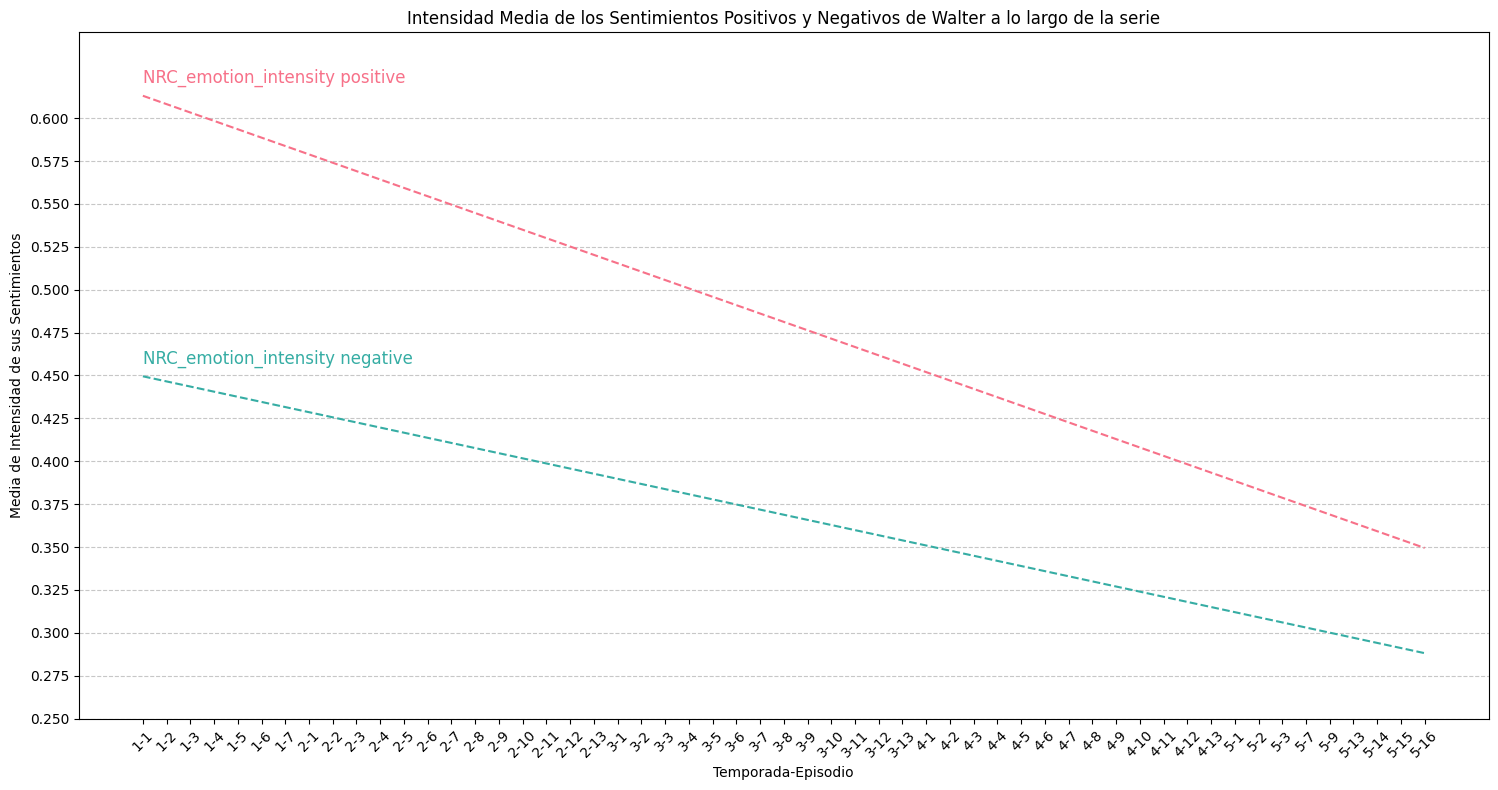

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns

# Assuming you already have grouped_df containing the NRC emotion intensities

# Define the emotions you want to plot
emotions_to_plot = ['NRC_emotion_intensity positive', 'NRC_emotion_intensity negative']

# Step 1: Melt the dataframe for easier plotting (assuming grouped_df contains the necessary data)
nrc_emotions = ['NRC_emotion_intensity positive', 'NRC_emotion_intensity negative']
melted_df = pd.melt(grouped_df, id_vars=['Temporada', 'Episodio'],
                    value_vars=nrc_emotions,
                    var_name='Emotion',
                    value_name='Intensity')

# Step 2: Filter the dataframe for 'positive' and 'negative' emotions only
filtered_df = melted_df[melted_df['Emotion'].isin(emotions_to_plot)]

# Step 3: Create a combined identifier for the x-axis
filtered_df['x_index'] = filtered_df['Temporada'].astype(str) + '-' + filtered_df['Episodio'].astype(str)

# Define a color palette for the two emotions (you can manually assign two colors)
colors = sns.color_palette("husl", len(emotions_to_plot))

# Step 4: Plot the evolution of the selected emotions
plt.figure(figsize=(15, 8))

# Plot each emotion with a trend line
for i, emotion in enumerate(emotions_to_plot):
    # Filter data for the current emotion
    emotion_data = filtered_df[filtered_df['Emotion'] == emotion]

    # Fit a linear regression model
    x = np.arange(len(emotion_data)).reshape(-1, 1)  # X values as index
    y = emotion_data['Intensity'].values
    model = LinearRegression().fit(x, y)

    # Predict values
    y_pred = model.predict(x)

    # Plot trend line with a unique color
    plt.plot(emotion_data['x_index'], y_pred, linestyle='--', color=colors[i], label=f'Trend: {emotion}')

    # Annotate the emotion name at the end of the trend line
    plt.text(emotion_data['x_index'].iloc[0], y_pred[0] + 0.005, emotion, color=colors[i], verticalalignment='bottom', horizontalalignment='left', fontsize=12)

# Step 5: Customize the plot
plt.title('Intensidad Media de los Sentimientos Positivos y Negativos de Walter a lo largo de la serie')
plt.xlabel('Temporada-Episodio')
plt.ylabel('Media de Intensidad de sus Sentimientos')
plt.xticks(rotation=45)

# Set y-axis limits to provide space for labels
plt.ylim(0.250, 0.65)  # Adjust upper limit as necessary to provide space for labels

plt.tight_layout()

# Show grid lines for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis ticks with more intermediate values
y_ticks = np.arange(0.250, 0.625, 0.025)  # Adjust the step size as needed
plt.yticks(y_ticks)

# Step 6: Show the plot
plt.show()

In [82]:
final_df.shape

(16402, 29)

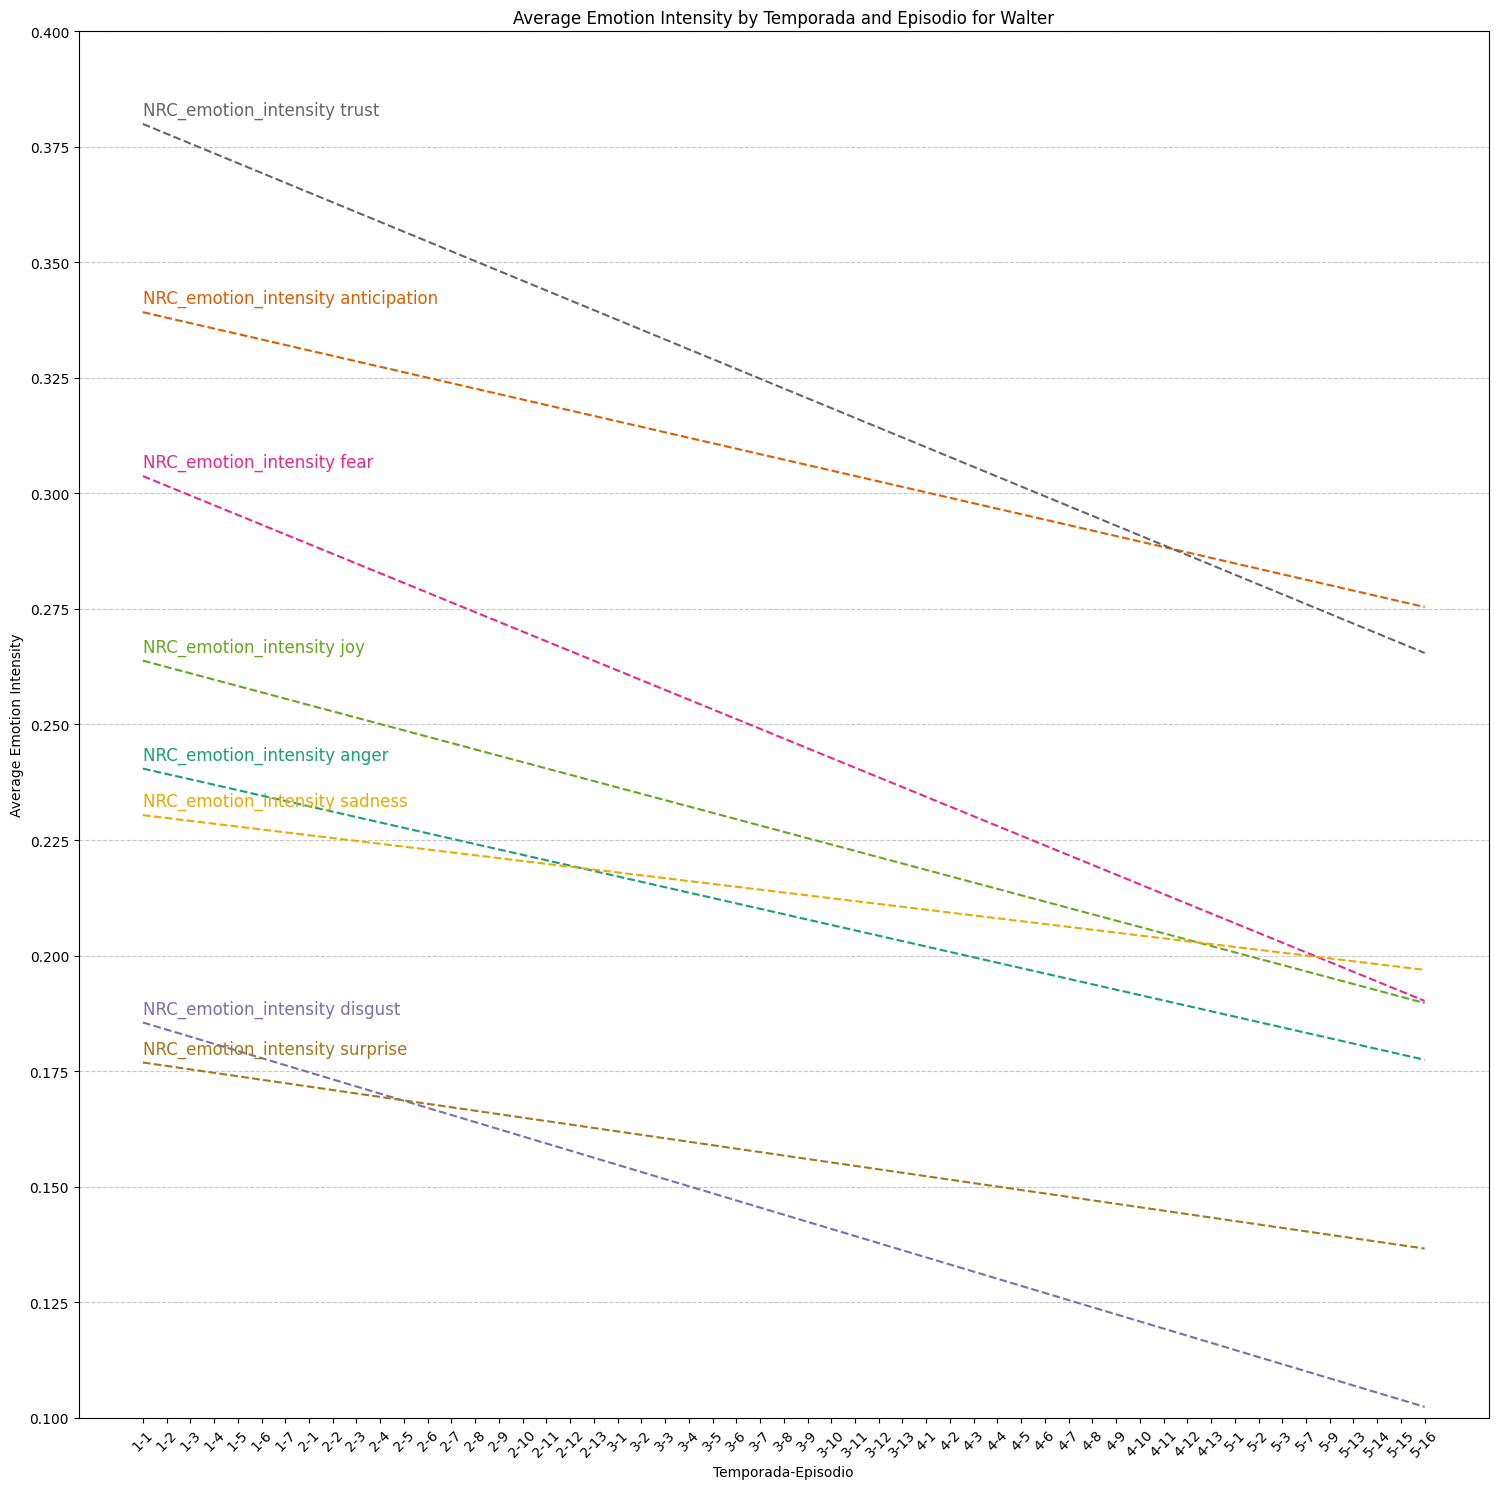

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

nrc_emotions = [col for col in final_df.columns if 'NRC_emotion_intensity ' in col]

# Step 1: Define the emotions to exclude
excluded_emotions = ['NRC_emotion_intensity positive', 'NRC_emotion_intensity negative']

# Step 2: Filter the emotions list
filtered_nrc_emotions = [emotion for emotion in nrc_emotions if emotion not in excluded_emotions]

# Step 3: Melt the dataframe for easier plotting
melted_df_2 = pd.melt(grouped_df, id_vars=['Temporada', 'Episodio'],
                    value_vars=filtered_nrc_emotions,
                    var_name='Emotion',
                    value_name='Intensity')

# Step 4: Create a combined identifier for x-axis
melted_df_2['x_index'] = melted_df_2['Temporada'].astype(str) + '-' + melted_df_2['Episodio'].astype(str)

# Define a color palette for trend lines
colors = sns.color_palette("Dark2", len(filtered_nrc_emotions))

# Step 5: Plot the evolution of emotions
plt.figure(figsize=(15, 15))

# Plot each emotion with a trend line
for i, emotion in enumerate(filtered_nrc_emotions):
    # Filter data for the current emotion
    emotion_data = melted_df_2[melted_df_2['Emotion'] == emotion]

    # Fit a linear regression model
    x = np.arange(len(emotion_data)).reshape(-1, 1)  # X values as index
    y = emotion_data['Intensity'].values
    model = LinearRegression().fit(x, y)

    # Predict values
    y_pred = model.predict(x)

    # Plot trend line with a unique color
    plt.plot(emotion_data['x_index'], y_pred, linestyle='--', color=colors[i], label=f'Trend: {emotion}')

    # Annotate the emotion name at the end of the trend line
    plt.text(emotion_data['x_index'].iloc[0], y_pred[0] + 0.005, emotion, color=colors[i], verticalalignment='top', horizontalalignment='left', fontsize=12)

# Step 6: Customize the plot
plt.title('Average Emotion Intensity by Temporada and Episodio for Walter')
plt.xlabel('Temporada-Episodio')
plt.ylabel('Average Emotion Intensity')
plt.xticks(rotation=45)

# Set y-axis limits to provide space for labels
plt.ylim(0.1, 0.4)  # Adjust upper limit as necessary to provide space for labels

plt.tight_layout()

# Show grid lines for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis ticks with more intermediate values
y_ticks = np.arange(0.1, 0.4, 0.025)  # Adjust the step size as needed
plt.yticks(y_ticks)

# Step 7: Show the plot
plt.show()

In [84]:
final_df.shape

(16402, 29)

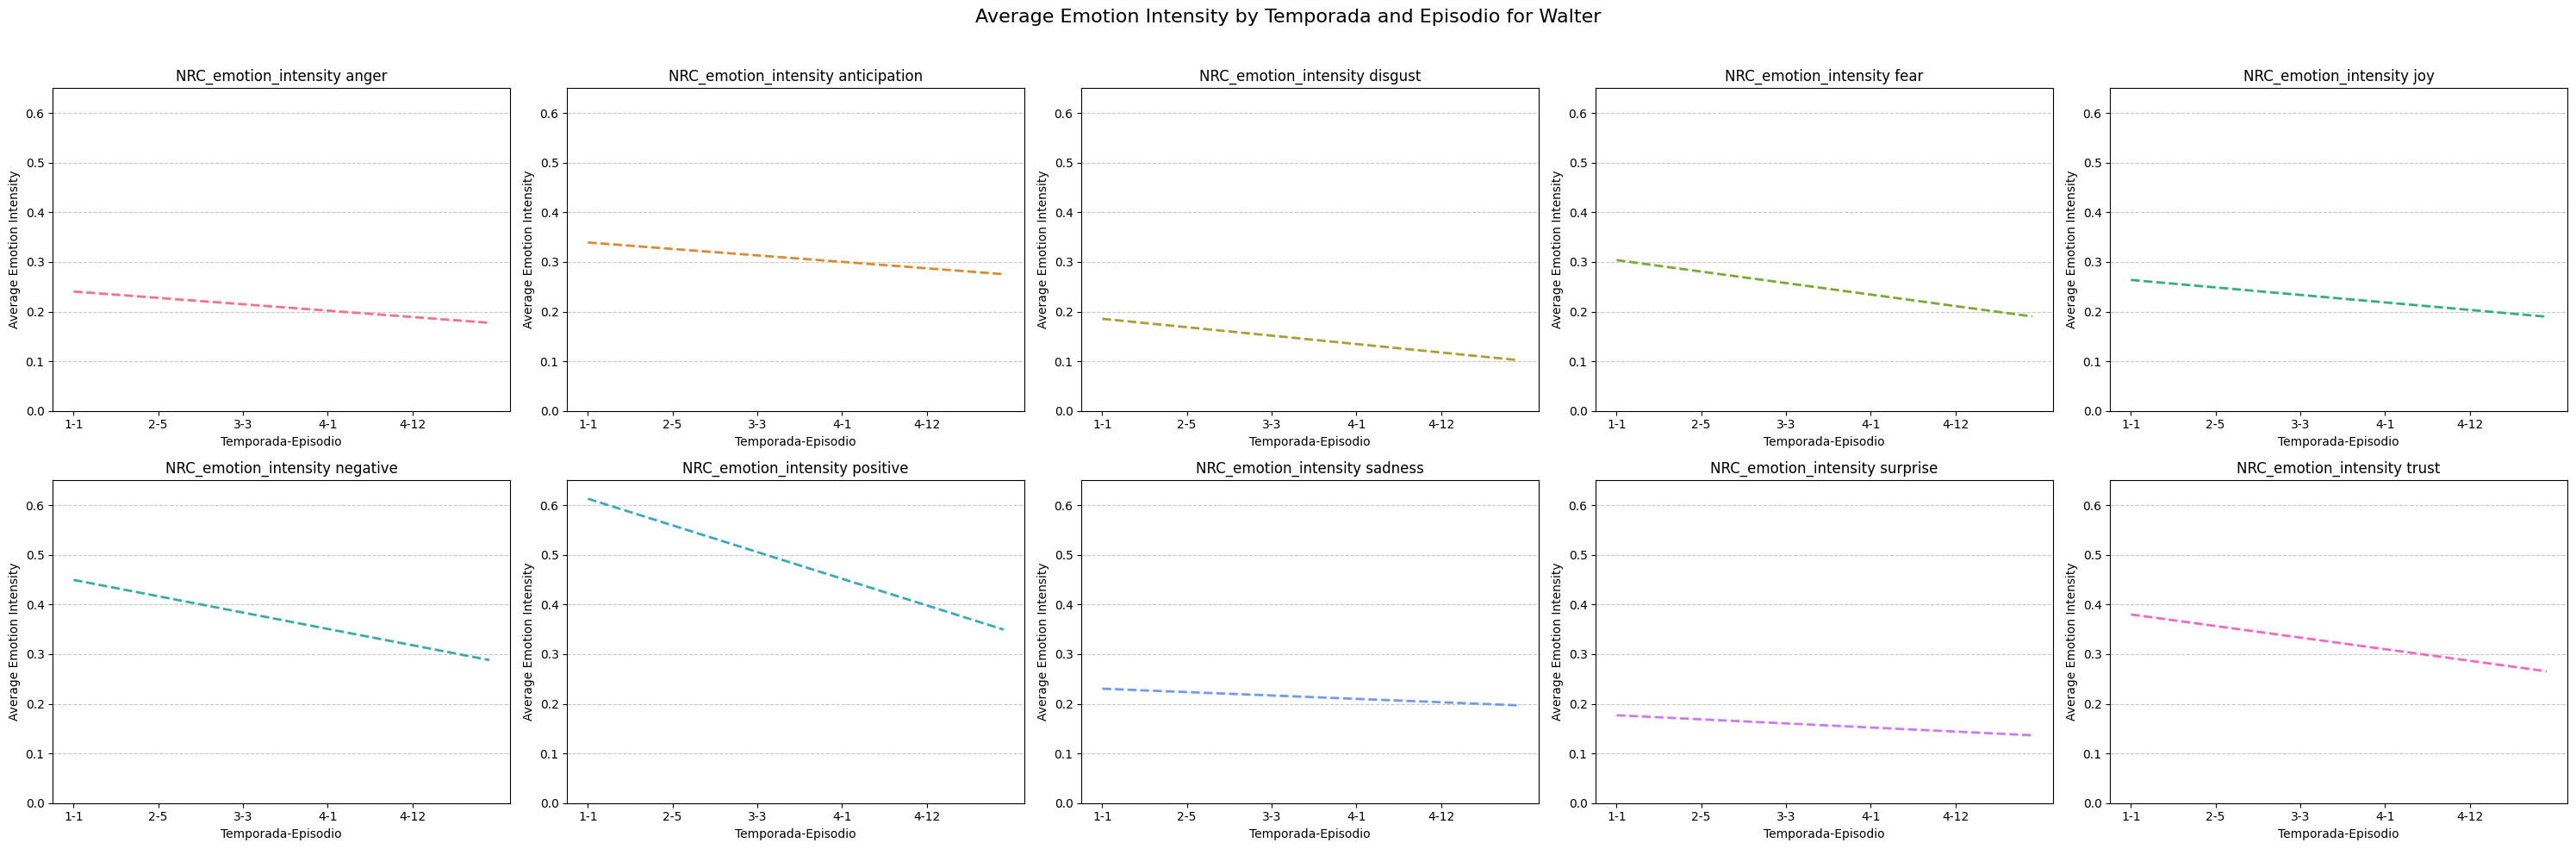

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Step 1: Melt the dataframe for easier plotting
melted_df = pd.melt(grouped_df, id_vars=['Temporada', 'Episodio'],
                    value_vars=nrc_emotions,
                    var_name='Emotion',
                    value_name='Intensity')

# Step 2: Create a combined identifier for x-axis
melted_df['x_index'] = melted_df['Temporada'].astype(str) + '-' + melted_df['Episodio'].astype(str)

# Define a color palette for trend lines
colors = sns.color_palette("husl", len(nrc_emotions))

# Step 3: Create subplots
fig, axs = plt.subplots(2, 5, figsize=(30, 10))  # 2 rows, 5 columns

# Flatten the axes array for easy indexing
axs = axs.flatten()

# Plot each emotion with a trend line
for i, emotion in enumerate(nrc_emotions):
    # Filter data for the current emotion
    emotion_data = melted_df[melted_df['Emotion'] == emotion]

    # Fit a linear regression model
    x = np.arange(len(emotion_data)).reshape(-1, 1)  # X values as index
    y = emotion_data['Intensity'].values
    model = LinearRegression().fit(x, y)

    # Predict values
    y_pred = model.predict(x)

    # Plot trend line with a unique color
    axs[i].plot(emotion_data['x_index'], y_pred, linestyle='--', color=colors[i], label=f'Trend: {emotion}', linewidth=2)

    # Annotate the emotion name at the end of the trend line
    # axs[i].text(emotion_data['x_index'].iloc[0], y_pred[0] + 0.005, emotion, color=colors[i],
    #             verticalalignment='top', horizontalalignment='left')

    # Customize each subplot
    axs[i].set_title(emotion)
    axs[i].set_xlabel('Temporada-Episodio')
    axs[i].set_ylabel('Average Emotion Intensity')
    axs[i].set_ylim(0, 0.65)  # Adjust upper limit as necessary to provide space for labels
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)
    axs[i].set_xticks(emotion_data['x_index'][::len(emotion_data)//5])  # Set x-ticks for clarity

# Set a common title for the entire figure
plt.suptitle('Average Emotion Intensity by Temporada and Episodio for Walter', fontsize=16)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the bottom to make space for the title

# Step 5: Show the plot
plt.show()

In [86]:
final_df.shape

(16402, 29)

## <font color='red'>Zero-shot con el modelo facebook/bart-large-mnli y la librería transformers de Hugging Face</font>

Se trata de un modelo entrenado específicamente para el procesamiento de lenguaje natural (NLP), que es perfecto para tareas de clasificación zero-shot.

### Instalar e importar las librerías, definir la función que obtiene el scoring de los sentimientos (positivo, negativo, neutro) y aplicarla a nuestro dataset

#### NO EJECUTAR, TARDA APROXIMADAMENTE 6 HORAS EN UN ORDENADOR NORMAL (CPU)

In [87]:
# !pip install transformers

In [88]:
# # NO EJECUTAR, TARDA APROXIMADAMENTE 6 HORAS EN UN ORDENADOR NORMAL

# # Import necessary libraries
#     from transformers import pipeline
#     import pandas as pd
#     import math
#     import numpy as np

#     try:
#         ready_df = pd.read_excel('C:/Users/maite/Desktop/IMMUNE/CAPSTONE/final_df.xlsx', index_col=None)

#         # Verificar si ready_df es un DataFrame
#         # if isinstance(ready_df, pd.DataFrame):
#         #     print("ready_df es un DataFrame")
#         # else:
#         #     print("ready_df NO es un DataFrame")

#     except ValueError as e:
#         print(f'Error de formato del archivo Excel: {e}')
#     except FileNotFoundError as e:
#         print(f'Error al encontrar el archivo: {e}')
#     except pd.errors.ParserError as e:
#         print(f'Error al analizar el archivo Excel: {e}')
#     except Exception as e:
#         print(f'Error desconocido: {e}')

#     # Initialize the zero-shot classification pipeline using the roberta-large-mnli model
#     classifier = pipeline("zero-shot-classification", model="roberta-large-mnli")

#     # Define candidate labels for classification
#     candidate_labels = ["positive", "negative", "neutral"]

#     texts = ready_df['Texto'].tolist()  # Get all texts at once
#     batch_size = 16  # Choose an appropriate batch size
#     results = []

#     for i in range(0, len(texts), batch_size):
#         batch_texts = texts[i:i + batch_size]
#         batch_results = classifier(batch_texts, candidate_labels)
#         results.extend(batch_results)
#         print(batch_results)

#     ready_df['RoBERTa_classification'] = None

#     # Add the classification results back to the DataFrame
#     for idx, result in enumerate(results):
#         ready_df.at[idx, 'RoBERTa_classification'] = result

#     output_file = "C:/Users/maite/Desktop/IMMUNE/CAPSTONE/RoBERTa_classification_0510.xlsx"
#     ready_df.to_excel(output_file, index=False)  # index=False to avoid adding index as a column

Como este algoritmo tarda 6 horas en ejecutarse, lo hemos realizado previamente y descargado los resultados en un excel aparte que importaremos posteriormente para ganar tiempo.

### Importar la extracción previa de los resultados de este algoritmo, añadirla al dataset existente y separar los valores en columnas ordenadas

In [89]:
# prompt: import excel file

import pandas as pd

# Replace 'your_excel_file.xlsx' with the actual path to your Excel file in Google Drive
excel_file_path = '/content/drive/MyDrive/CAPSTONE/preprocessing_wip_Maite/RoBERTa_classification.xlsx'

roberta_df = pd.read_excel(excel_file_path)

roberta_df.head(2)

,RoBERTa_classification
0,"{""sequence"":""My name is Walter Hartwell White...."
1,"{""sequence"":""White Residence"", ""labels"":[""posi..."


In [90]:
roberta_df.shape

(16402, 1)

In [91]:
roberta_df.columns

Index(['RoBERTa_classification'], dtype='object')

In [92]:
import json
import re

# Function to sanitize JSON-like strings
def sanitize_json_string(entry):
    # Remove unescaped backslashes
    entry = re.sub(r'\\(?!["\\/bfnrt])', '', entry)
    # Replace any unescaped quotes inside the string
    entry = entry.replace('\\"', '"')
    return entry

# Function to parse each entry in classification_result
def parse_classification_result(entry):
    if isinstance(entry, str):  # If it's a string, try to parse it as JSON
        try:
            # Sanitize the JSON string
            sanitized_entry = sanitize_json_string(entry)
            # Parse the JSON string to a Python object (list of dictionaries)
            return json.loads(sanitized_entry)
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON at entry: {sanitized_entry}\nError: {e}")
            return None  # If parsing fails, return None
    elif isinstance(entry, list):  # If it's already a list of dictionaries
        return entry
    else:
        return None  # Handle other cases

# Apply the function to the classification_result column
roberta_df['RoBERTa_classification'] = roberta_df['RoBERTa_classification'].apply(parse_classification_result)

# Check if it worked by inspecting a few rows
print(roberta_df['RoBERTa_classification'].head(2))

0    {'sequence': 'My name is Walter Hartwell White...
1    {'sequence': 'White Residence', 'labels': ['po...
Name: RoBERTa_classification, dtype: object


In [93]:
roberta_df['RoBERTa_classification'].head(2)

,RoBERTa_classification
0,{'sequence': 'My name is Walter Hartwell White...
1,"{'sequence': 'White Residence', 'labels': ['po..."


In [94]:
# Now extract 'labels', 'scores', and 'sequence' from the dictionary
roberta_df['labels'] = roberta_df['RoBERTa_classification'].apply(lambda x: x['labels'] if isinstance(x, dict) else None)
roberta_df['scores'] = roberta_df['RoBERTa_classification'].apply(lambda x: x['scores'] if isinstance(x, dict) else None)
roberta_df['sequence'] = roberta_df['RoBERTa_classification'].apply(lambda x: x['sequence'] if isinstance(x, dict) else None)

# Display the result
# print(df[['sequence', 'labels', 'scores']].head(2))

In [95]:
final_df.shape

(16402, 29)

In [96]:
roberta_df['label_score_pairs'] = roberta_df.apply(
    lambda row: list(zip(row['labels'], row['scores'])) if row['labels'] is not None and row['scores'] is not None else None,
    axis=1
)

# Display the result with label-score pairs
print(df['label_score_pairs'].head())

0    [(neutral, 0.39315372705459595), (negative, 0....
1    [(positive, 0.5158714056015015), (neutral, 0.3...
2    [(negative, 0.45629429817199707), (neutral, 0....
3    [(positive, 0.9286181926727295), (neutral, 0.0...
4    [(positive, 0.3990820050239563), (negative, 0....
Name: label_score_pairs, dtype: object


In [97]:
# Create columns for positive, negative, and neutral scores
roberta_df['RoBERTa_positive'] = 0.0
roberta_df['RoBERTa_negative'] = 0.0
roberta_df['RoBERTa_neutral'] = 0.0

# Assign scores to the respective columns based on labels
for index, row in df.iterrows():
    if row['label_score_pairs'] is not None:
        for label, score in row['label_score_pairs']:
            if label == 'positive':
                roberta_df.at[index, 'RoBERTa_positive'] = score
            elif label == 'negative':
                roberta_df.at[index, 'RoBERTa_negative'] = score
            elif label == 'neutral':
                roberta_df.at[index, 'RoBERTa_neutral'] = score

# Display the result with the new columns
print(roberta_df[['RoBERTa_positive', 'RoBERTa_negative', 'RoBERTa_neutral']].head())

   RoBERTa_positive  RoBERTa_negative  RoBERTa_neutral
0           0.25047           0.35638          0.39315
1           0.51587           0.18188          0.30225
2           0.16580           0.45629          0.37791
3           0.92862           0.01312          0.05826
4           0.39908           0.34902          0.25190


In [98]:
roberta_df = roberta_df.drop(columns=['RoBERTa_classification','sequence', 'labels', 'scores', 'label_score_pairs'])
df.head(2)

,RoBERTa_positive,RoBERTa_negative,RoBERTa_neutral
0,0.25047,0.35638,0.39315
1,0.51587,0.18188,0.30225


In [99]:
print(final_df.shape)  # Check the shape of final_df
print(roberta_df.shape)        # Check the shape of df

(16402, 29)
(16402, 3)


In [100]:
# Reset index before concatenation
final_df = final_df.reset_index(drop=True)
roberta_df = roberta_df.reset_index(drop=True)

# Now concatenate
ready_df = pd.concat([final_df, roberta_df], axis=1)

# Check the result
print(ready_df.shape)  # Check if the row count is correct

(16402, 32)


In [101]:
final_df.shape

(16402, 29)

In [ ]:
roberta_df.shape

In [102]:
ready_df.shape

(16402, 32)

### Dibujar el Histograma de los sentimientos extraídos con ZERO-SHOT TRANSFORMERS Y MODELO DE FACEBOOK para ver su distribución
Vemos que hay una enorme cantidad de valores neutros (cero o cercanos a cero) en todos los scorings (negativo, positivo, neutro y compound).

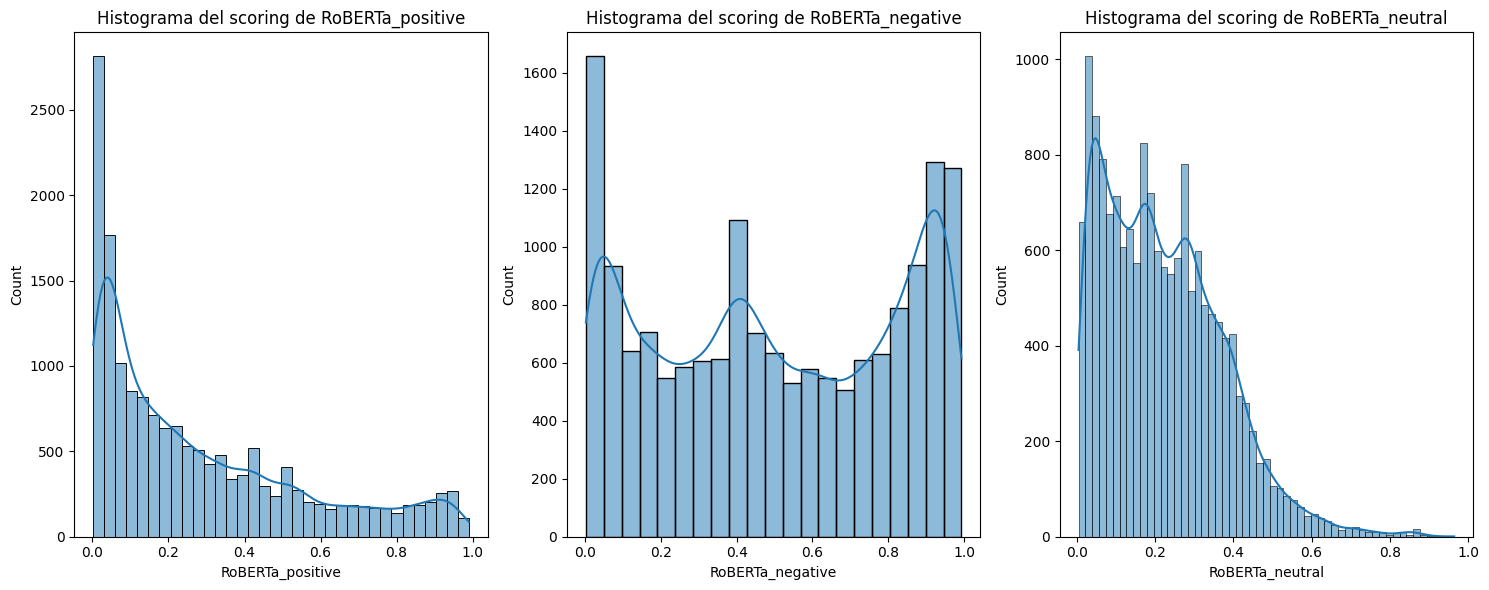

In [104]:
# Set up the 2x2 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Realizar plot de sentiwordnet_negative
sns.histplot(ready_df['RoBERTa_positive'], kde=True, ax=axes[0])
axes[0].set_title('Histograma del scoring de RoBERTa_positive')

# Realizar plot de sentiwordnet_positive
sns.histplot(ready_df['RoBERTa_negative'], kde=True, ax=axes[1])
axes[1].set_title('Histograma del scoring de RoBERTa_negative')

# Realizar plot de sentiwordnet_compound
sns.histplot(ready_df['RoBERTa_neutral'], kde=True, ax=axes[2])
axes[2].set_title('Histograma del scoring de RoBERTa_neutral')

plt.tight_layout()
plt.show()

Vemos que hay bastantes valores en torno al cero, no obstante, en esta ocasión, el scoring está más equilibrado para las tres variables, por lo que no realizaremos la eliminación del 90% de estos valores que hemos realizado previamente.

### Quitar el 50% de los valores para equilibrar el dataset.

In [105]:
zeroshot_vars = ['RoBERTa_positive', 'RoBERTa_negative', 'RoBERTa_neutral']

In [ ]:
# # Filtramos las filas que tienen un valor en torno a cero en cada variable de zeroshot
# neutros_dict = {}  # Para almacenar el DataFrame de neutros de cada variable

# # Inicializamos `final_df_reducido` como una copia de `final_df` para trabajar sobre ella sin modificar la original
# final_df_reducido = final_df.copy()

# for var in zeroshot_vars:
#     # Filtrar las filas donde el valor de la variable está entre 0 y 0.02
#     neutros = final_df_reducido[(final_df_reducido[var] >= 0.0) & (final_df_reducido[var] <= 0.2)]

#     # Seleccionamos una muestra aleatoria del 50% de las filas en el rango definido
#     neutros_a_eliminar = neutros.sample(frac=0.9, random_state=10)

#     # Eliminamos esas filas del dataset reducido
#     final_df_reducido = final_df_reducido.drop(neutros_a_eliminar.index)

#     # Guardar el número de neutros restantes para verificación
#     neutros_restantes = final_df_reducido[(final_df_reducido[var] >= 0.0) & (final_df_reducido[var] <= 0.02)]
#     neutros_dict[var] = {
#         "original": len(neutros),
#         "remaining": len(neutros_restantes)
#     }

# # Verificamos que el número de neutros se ha reducido adecuadamente
# for var, counts in neutros_dict.items():
#     print(f"Número original de {var}: {counts['original']}")
#     print(f"Número de {var} restantes tras eliminación (50%): {counts['remaining']}")

### Agrupar sentimientos por la media y la mediana de cada episodio y realizar distintos plots

In [107]:
zeroshot_media_episodio = {}

for var in zeroshot_vars:
    zeroshot_media_episodio[var] = ready_df.groupby(['Temporada', 'Episodio'])[var].mean().reset_index()

for var in zeroshot_vars:
    print(f"\nGrouped mean for {var}:\n", zeroshot_media_episodio[var])


Grouped mean for RoBERTa_positive:
     Temporada  Episodio  RoBERTa_positive
0           1         1           0.28444
1           1         2           0.23642
2           1         3           0.18741
3           1         4           0.31388
4           1         5           0.30290
5           1         6           0.25957
6           1         7           0.28887
7           2         1           0.21203
8           2         2           0.20656
9           2         3           0.23665
10          2         4           0.27589
11          2         5           0.27326
12          2         6           0.27783
13          2         7           0.30429
14          2         8           0.20070
15          2         9           0.24468
16          2        10           0.31558
17          2        11           0.24811
18          2        12           0.30618
19          2        13           0.32318
20          3         1           0.29567
21          3         2           0.263

#### Scatterplot de tendencia de la Polaridad de Sentimiento a lo largo de toda la serie para Walter

In [108]:
final_df_walter = ready_df[ready_df['Personaje'] == 'jesse']

zeroshot_media_episodio_walter = {}

for var in zeroshot_vars:
    zeroshot_media_episodio_walter[var] = final_df_walter.groupby(['Temporada', 'Episodio'])[var].mean().reset_index()

for var in zeroshot_vars:
    print(f"\nGrouped mean for {var}:\n", zeroshot_media_episodio_walter[var])


Grouped mean for RoBERTa_positive:
     Temporada  Episodio  RoBERTa_positive
0           1         1           0.24445
1           1         2           0.18572
2           1         3           0.12921
3           1         4           0.37454
4           1         5           0.30640
5           1         6           0.20644
6           1         7           0.15270
7           2         1           0.14899
8           2         2           0.14300
9           2         3           0.20437
10          2         4           0.18933
11          2         5           0.33422
12          2         6           0.16937
13          2         7           0.24941
14          2         8           0.20005
15          2         9           0.20837
16          2        10           0.28913
17          2        11           0.25160
18          2        12           0.23358
19          2        13           0.28015
20          3         1           0.19604
21          3         2           0.600

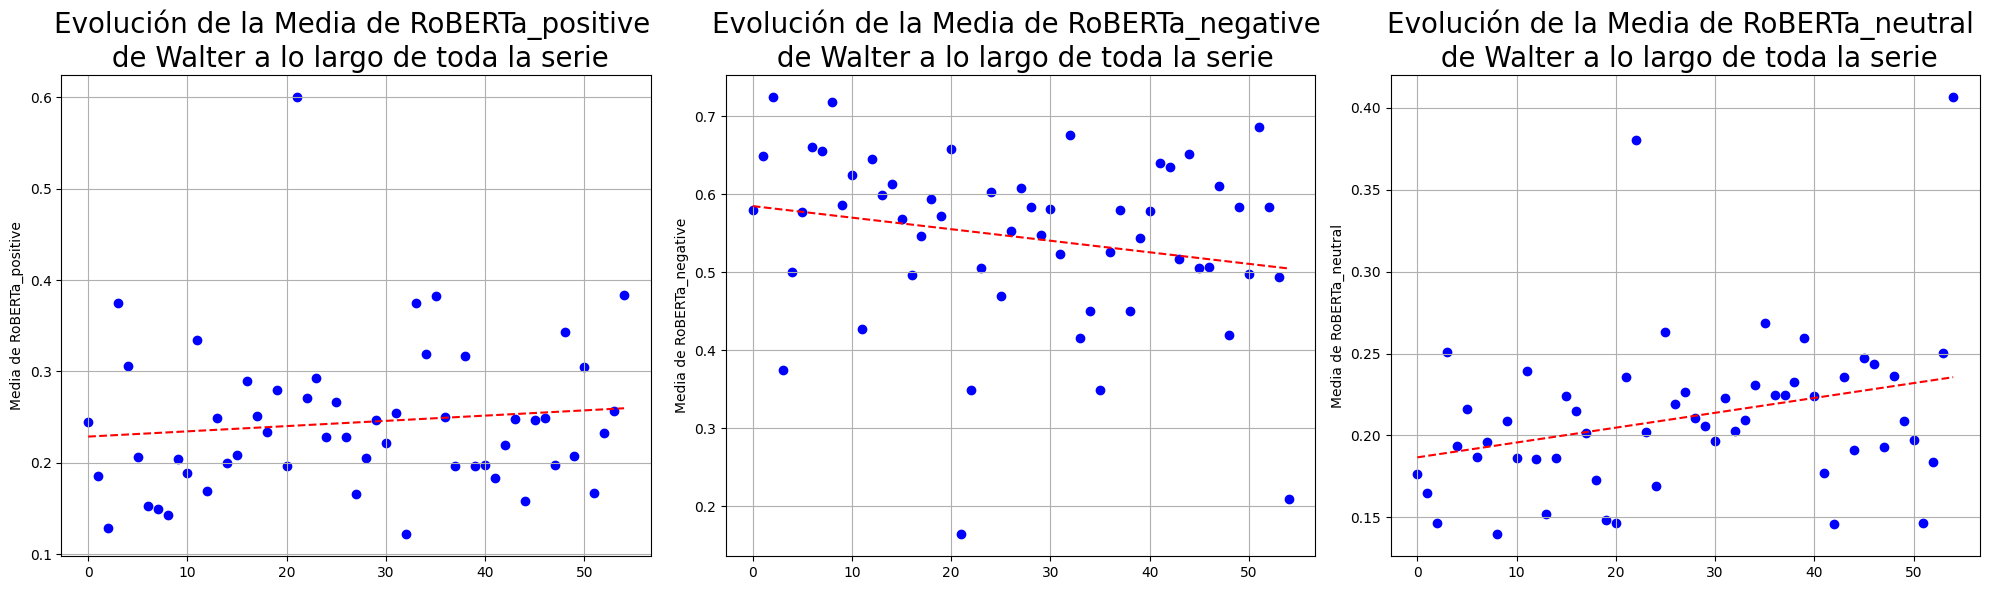

In [119]:
fig, axs = plt.subplots(1, len(zeroshot_vars), figsize=(20, 2 * len(zeroshot_vars)), sharex=True)

for i, var in enumerate(zeroshot_vars):

    # Assuming each var has a DataFrame with 'mean' and 'median' data
    plot_media_episodio_walter = zeroshot_media_episodio_walter[var]

    # First subplot: Mean
    axs[i].scatter(plot_media_episodio_walter.index, plot_media_episodio_walter[var], color='blue', label='Media de ' + var + ' de Walter a lo largo de toda la serie')

    # Fit a linear regression line for the mean
    X_mean = plot_media_episodio_walter.index.values.reshape(-1, 1)  # Reshape for sklearn
    y_mean = plot_media_episodio_walter[var].values  # Ensure you access the values correctly
    model_mean = LinearRegression().fit(X_mean, y_mean)
    y_pred_mean = model_mean.predict(X_mean)

    # Plot trend line for mean
    axs[i].plot(plot_media_episodio_walter.index, y_pred_mean, color='red', linestyle='--', label='Tendencia Media')

    # Titles and labels for the first subplot
    axs[i].set_title(f'Evolución de la Media de {var} \n de Walter a lo largo de toda la serie', fontsize=20)
    axs[i].set_ylabel(f'Media de {var}')
    # axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [111]:
output_path = '/content/drive/MyDrive/CAPSTONE/preprocessing_wip_Maite/ready_df.xlsx'

ready_df.to_excel(output_path, index=False)